In [1]:
## Cargo las librerias
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
 
##Cargo librerias de scraping web
import re 

##Librerias de tiempo
import time
from datetime import datetime
import time

###Librerias para el conteno de palabras (subtitulos)
from sklearn.feature_extraction.text import CountVectorizer
import nltk as nl
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import string as st
import jellyfish as jel
from itertools import product


##Graficos
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

In [2]:
#################################################################################################################################
##Importo el archivo
#################################################################################################################################
#generos_frec = pd.read_csv('./5_generos_frec.csv', sep = ';')
movie_completo = pd.read_csv('./4_movie_completo.csv', sep = ';')
nrc_lexicon = pd.read_csv('./nrc_lexicon.csv', sep = ';')

In [3]:
print(movie_completo.shape)
print(nrc_lexicon.shape)

(3295, 18480)
(13901, 2)


In [5]:
nrc_lexicon.head()

,word,sentiment
0,abacus,trust
1,abandon,fear
2,abandon,negative
3,abandon,sadness
4,abandoned,anger


In [216]:
generos_frec=generos_frec.loc[~generos_frec.word.isnull(),:]

In [217]:
### Hago un join a lo bruto con el lexicon
junta=pd.merge(left=generos_frec, right=nrc_lexicon, on='word')

In [218]:
junta.shape

(4806, 14)

In [220]:
junta.columns
junta[['frec_Drama', 'frec_Comedy', 'frec_Action', 'frec_Adventure',
               'frec_Crime', 'frec_Family', 'frec_Fantasy', 'frec_Horror',
               'frec_Mystery', 'frec_Romance', 'frec_Sci-Fi', 'frec_Thriller',
               'sentiment']].groupby('sentiment').sum()

In [30]:
##Hago el producto cartesiano entre las palabras y le calculo la distancia de Jaro_winkler para saber cuales son similares
##http://jellyfish.readthedocs.io/en/latest/comparison.html#jaro-winkler-distance
def compara_word (lista1, lista2, corte=0.9):
    ##Inicializo las variables
    macheo_sent=pd.DataFrame()
    cant_proc = 0
    hora_ini = datetime.now()
    
    ##hago el producto cartesiano de las palabras y recorro cada par
    for word1, word2 in product(lista1, lista2):
        try:
            #Calculo la distancia de cada palabra
            dist = jel.jaro_winkler(word1, word2)
            
            if dist >= corte:
                dic = {'word_genero': word1, 'word_lexi': word2, 'dist_jaro': dist}
                dic = pd.DataFrame(dic, index= {cant_proc})
                macheo_sent = pd.concat([macheo_sent, dic])
            cant_proc +=1
            #if cant_proc%(len(lista1)*len(lista2)/10)==0:
            #    print('cant palabras procesadas:', cant_proc, 'de un total de:', len(lista1)*len(lista2), 'Duration: {}'.format(datetime.now() - hora_ini))
        except Exception as e:
                print("Hubo un error en las palabras", word1, 'y', word2)
                print(e, "\n")
                continue
    return macheo_sent

In [224]:
list1 = generos_frec.word
list2 = np.unique(nrc_lexicon.loc[~nrc_lexicon.sentiment.isin(['positive', 'negative']), 'word']).tolist()

macheo_sent = compara_word (list1, list2, corte=0.95)

In [225]:
macheo_sent.shape

(3646, 3)

In [226]:
##Joineo con la tabla generos_frec
junta2 = pd.merge(left= generos_frec, right = macheo_sent, left_on='word', right_on='word_genero')

In [227]:
junta2.shape

(3646, 16)

In [228]:
###Joineo con el lexicon
junta3 = pd.merge(left= junta2, right = nrc_lexicon.loc[~nrc_lexicon.sentiment.isin(['positive', 'negative']), :], left_on='word_lexi', right_on='word')

In [229]:
junta3.shape

(6873, 18)

In [230]:
junta3[['frec_Drama', 'frec_Comedy', 'frec_Action', 'frec_Adventure',
       'frec_Crime', 'frec_Family', 'frec_Fantasy', 'frec_Horror',
       'frec_Mystery', 'frec_Romance', 'frec_Sci-Fi', 'frec_Thriller',
       'sentiment']].groupby('sentiment').sum()

,frec_Drama,frec_Comedy,frec_Action,frec_Adventure,frec_Crime,frec_Family,frec_Fantasy,frec_Horror,frec_Mystery,frec_Romance,frec_Sci-Fi,frec_Thriller
sentiment,,,,,,,,,,,,
anger,181530.0,118958.0,56936.0,33354.0,34101.0,4823.0,5187.0,16773.0,6320.0,22971.0,7068.0,30199.0
anticipation,173192.0,114453.0,43914.0,31421.0,24912.0,5185.0,4452.0,12045.0,5446.0,23955.0,6261.0,23407.0
disgust,116084.0,81373.0,35466.0,21911.0,21587.0,3261.0,3667.0,12824.0,4256.0,16097.0,4879.0,20067.0
fear,188741.0,116776.0,63869.0,40262.0,35061.0,5534.0,6096.0,18696.0,7377.0,24108.0,8479.0,33025.0
joy,171012.0,118581.0,40479.0,27900.0,22703.0,5228.0,4364.0,10880.0,4784.0,24153.0,5403.0,20371.0
sadness,167986.0,105692.0,46815.0,29166.0,28405.0,4810.0,4970.0,14973.0,6286.0,22273.0,6248.0,25604.0
surprise,114074.0,78982.0,30840.0,20648.0,18519.0,3506.0,3026.0,8702.0,3851.0,15865.0,4161.0,16980.0
trust,282994.0,167306.0,76869.0,48191.0,42389.0,7870.0,6711.0,18003.0,9025.0,34794.0,10094.0,38011.0


In [150]:
junta3[['frec_Drama', 'frec_Comedy', 'frec_Action', 'frec_Adventure',
       'frec_Crime', 'frec_Family', 'frec_Fantasy', 'frec_Horror',
       'frec_Mystery', 'frec_Romance', 'frec_Sci-Fi', 'frec_Thriller',
       'sentiment']].groupby('sentiment').sum().to_csv('sentimientoxgenero.csv', sep=';', index = True)

## No se ve nada en forma global

In [4]:
def find_sentimientos(imdb_id):
    ##Campos a excluir
    exclude = ['imdb_id','actors', 'awards', 'box_office', 'country', 'director_y', 'dvd_y',
               'genre', 'id_movie', 'imdb_rating', 'imdb_votes', 'language',
               'metascore', 'plot_y', 'poster_y', 'production', 'rated', 'released',
               'response', 'runtime', 'title', 'type_y', 'website', 'writer_y', 'year', 'genero']
    include = [x for x in list(movie_completo.columns) if x not in exclude]

    ##Me quedo con la pelicula que quiero graficar los sentimientos
    movie_filtrada = movie_completo.loc[movie_completo.imdb_id == imdb_id, include]

    ##Le agrego como inidice el nombre de la pelicula
    movie_filtrada.index = movie_completo.loc[movie_completo.imdb_id == imdb_id, 'title']

    ##Filtro las palabras que tienen frecuencia mayor que 0
    movie_filtrada = movie_filtrada.loc[:, [x for x in list(movie_filtrada.columns) if movie_filtrada.loc[:,x].values>0]]

    ##Transformo el data set para que me quede un registro por palabra y no una palabra por columna
    movie_filtrada_row = pd.DataFrame({'word': movie_filtrada.columns.tolist(), 'frec': movie_filtrada.values.tolist()[0]})
    
    ##Genero una lista con las palabras de la pelicula
    list1 = movie_filtrada_row.word
    ##Genero una lista con el lexicon
    list2 = np.unique(nrc_lexicon.loc[~nrc_lexicon.sentiment.isin(['positive', 'negative']), 'word']).tolist()

    ##Aplico la funcion que calcula distancia entre las palabras
    macheo_sent = compara_word (list1, list2, corte=0.95)

    ##Joineo con la tabla generos_frec
    junta = pd.merge(left= movie_filtrada_row, right = macheo_sent, left_on='word', right_on='word_genero')
    
    ##Borro la columna word de movie_filtrada
    junta= junta.drop('word', axis=1)
    
    ###Joineo con el lexicon
    junta = pd.merge(left= junta, right = nrc_lexicon.loc[~nrc_lexicon.sentiment.isin(['positive', 'negative']), :], left_on='word_lexi', right_on='word')
    
    return junta

In [145]:
##Trabajo peliculas en forma individual
#tt2023587 Mama
#tt0034492 Bambi
#tt0054215 pscho
#tt2567026 alicia
#tt1120985 blue valentine
#tt0112471 before surnrise
#tt0484740 amor en los tiempos del colera

junta=find_sentimientos('tt0034492')

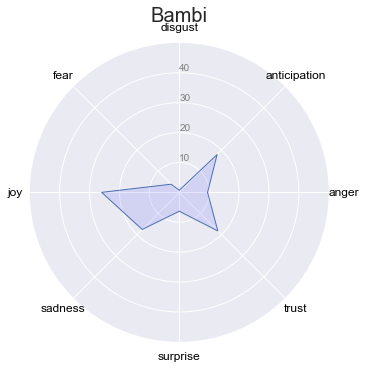

In [148]:
## Grafico
agrupado = junta.groupby('sentiment').sum()['frec']/junta.groupby('sentiment').sum()['frec'].sum()*100
sent = agrupado.index.tolist()
values = agrupado.values.tolist()


N = len(sent)

values += values[:1]
values


# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], sent, color='black', size=12)
 
# Draw ylabels
ax.set_rlabel_position(90)
plt.yticks([10,20, 30, 40], ["10","20", "30", "40"], color="grey", size=10)
plt.ylim(0,50)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

# Agrego el titulo
ax.axes.set_title(movie_completo.loc[movie_completo.imdb_id == 'tt0034492', 'title'].values[0],fontsize=20)

#Guardo el grafico
plt.savefig('./graficos_sentimientos/'+movie_completo.loc[movie_completo.imdb_id == 'tt0034492', 'title'].values[0]+'.png')

In [141]:
agrupado

sentiment
anger            7.619048
anticipation    11.047619
disgust          6.285714
fear             7.428571
joy             13.904762
sadness         10.857143
surprise         6.476190
trust           36.380952
Name: frec, dtype: float64

In [153]:
hora_ini = datetime.now()
cant=0

for i in movie_completo.loc[movie_completo.genero == 'Horror', 'imdb_id']:
    
    junta = find_sentimientos(i)
    
    ## Grafico
    agrupado = junta.groupby('sentiment').sum()['frec']/junta.groupby('sentiment').sum()['frec'].sum()*100
    sent = agrupado.index.tolist()
    values = agrupado.values.tolist()

    N = len(sent)

    values += values[:1]
    values

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], sent, color='black', size=12)

    # Draw ylabels
    ax.set_rlabel_position(90)
    plt.yticks([10,20, 30, 40], ["10","20", "30", "40"], color="grey", size=10)
    plt.ylim(0,50)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    # Agrego el titulo
    ax.axes.set_title(movie_completo.loc[movie_completo.imdb_id == i, 'title'].values[0],fontsize=20)

    #Guardo el grafico
    plt.savefig('./graficos_sentimientos/'+movie_completo.loc[movie_completo.imdb_id == i, 'title'].values[0]+'.png')
    plt.close()
    
    cant += 1
    print('cant_procesadas:',cant, 'de',len(movie_completo.loc[movie_completo.genero == 'Horror', 'imdb_id']) ,'Duration: {}'.format(datetime.now() - hora_ini))

cant_procesadas: 1 de 128 Duration: 0:00:24.270124
cant_procesadas: 2 de 128 Duration: 0:00:50.494096
cant_procesadas: 3 de 128 Duration: 0:01:13.342668
cant_procesadas: 4 de 128 Duration: 0:01:35.348695
cant_procesadas: 5 de 128 Duration: 0:01:57.012756
cant_procesadas: 6 de 128 Duration: 0:02:18.233100
cant_procesadas: 7 de 128 Duration: 0:02:39.716747
cant_procesadas: 8 de 128 Duration: 0:03:01.489781
cant_procesadas: 9 de 128 Duration: 0:03:22.888263
cant_procesadas: 10 de 128 Duration: 0:03:44.440019
cant_procesadas: 11 de 128 Duration: 0:04:05.571798
cant_procesadas: 12 de 128 Duration: 0:04:26.802609
cant_procesadas: 13 de 128 Duration: 0:04:49.214755
cant_procesadas: 14 de 128 Duration: 0:05:10.653161
cant_procesadas: 15 de 128 Duration: 0:05:32.522902
cant_procesadas: 16 de 128 Duration: 0:05:54.004855
cant_procesadas: 17 de 128 Duration: 0:06:17.208321
cant_procesadas: 18 de 128 Duration: 0:06:40.105356
cant_procesadas: 19 de 128 Duration: 0:07:02.707765
cant_procesadas: 20 d

In [8]:
### Calculo las peliculas con mayor porcentaje en cada sentimiento
#Inicializo el data frame agrupado max
agrupado_max = pd.DataFrame({'frec':[0.00001]*8, 'imdb_id':['']*8}, index=['anger','anticipation','disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'])
hora_ini = datetime.now()
cant=0

for i in movie_completo.loc[:, 'imdb_id']:
    ##Calculo las distancias
    junta = find_sentimientos(i)
    ##Agrupo
    agrupado = junta.groupby('sentiment').sum()['frec']/junta.groupby('sentiment').sum()['frec'].sum()*100
    ## Comparo con el maximo
    if len(agrupado) == 8:
        for j in range(len(agrupado_max.index)):
            if agrupado_max.frec[j] <= agrupado[j]:
                agrupado_max.frec[j] = agrupado[j]
                agrupado_max.imdb_id[j] = i
    
    cant += 1
    
    print('cant_procesadas:',cant, 'de',len(movie_completo.loc[:, 'imdb_id']) ,'Duration: {}'.format(datetime.now() - hora_ini))

C:\Users\MCOLOMBINI\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\MCOLOMBINI\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cant_procesadas: 1 de 3295 Duration: 0:02:05.942963
cant_procesadas: 2 de 3295 Duration: 0:04:23.367281
cant_procesadas: 3 de 3295 Duration: 0:04:36.154006
cant_procesadas: 4 de 3295 Duration: 0:06:45.191524
cant_procesadas: 5 de 3295 Duration: 0:08:37.229748
cant_procesadas: 6 de 3295 Duration: 0:09:13.307800
cant_procesadas: 7 de 3295 Duration: 0:10:32.789284
cant_procesadas: 8 de 3295 Duration: 0:12:48.106510
cant palabras procesadas: 923841 de un total de: 4619205 Duration: 0:00:19.181057
cant palabras procesadas: 1847682 de un total de: 4619205 Duration: 0:00:46.840265
cant palabras procesadas: 2771523 de un total de: 4619205 Duration: 0:01:25.693769
cant palabras procesadas: 3695364 de un total de: 4619205 Duration: 0:02:14.159522
cant palabras procesadas: 4619205 de un total de: 4619205 Duration: 0:02:56.762528
cant_procesadas: 9 de 3295 Duration: 0:15:51.291437
cant palabras procesadas: 504319 de un total de: 5043190 Duration: 0:00:09.497041
cant palabras procesadas: 1008638 de

cant palabras procesadas: 1245177 de un total de: 4150590 Duration: 0:00:45.306708
cant palabras procesadas: 1660236 de un total de: 4150590 Duration: 0:00:56.480363
cant palabras procesadas: 2075295 de un total de: 4150590 Duration: 0:01:07.312224
cant palabras procesadas: 2490354 de un total de: 4150590 Duration: 0:01:18.504598
cant palabras procesadas: 2905413 de un total de: 4150590 Duration: 0:01:26.286335
cant palabras procesadas: 3320472 de un total de: 4150590 Duration: 0:01:37.589412
cant palabras procesadas: 3735531 de un total de: 4150590 Duration: 0:01:48.644274
cant palabras procesadas: 4150590 de un total de: 4150590 Duration: 0:01:59.208976
cant_procesadas: 52 de 3295 Duration: 1:34:21.860195
cant_procesadas: 53 de 3295 Duration: 1:36:34.580904
cant_procesadas: 54 de 3295 Duration: 1:39:38.522159
cant_procesadas: 55 de 3295 Duration: 1:40:48.704537
cant_procesadas: 56 de 3295 Duration: 1:41:42.380984
cant_procesadas: 57 de 3295 Duration: 1:43:50.510045
cant_procesadas: 5

cant palabras procesadas: 1271955 de un total de: 4239850 Duration: 0:00:32.386056
cant palabras procesadas: 1695940 de un total de: 4239850 Duration: 0:00:44.642965
cant palabras procesadas: 2119925 de un total de: 4239850 Duration: 0:00:57.346658
cant palabras procesadas: 2543910 de un total de: 4239850 Duration: 0:01:07.857126
cant palabras procesadas: 2967895 de un total de: 4239850 Duration: 0:01:19.820242
cant palabras procesadas: 3391880 de un total de: 4239850 Duration: 0:01:34.194024
cant palabras procesadas: 3815865 de un total de: 4239850 Duration: 0:01:43.499972
cant palabras procesadas: 4239850 de un total de: 4239850 Duration: 0:01:48.539282
cant_procesadas: 91 de 3295 Duration: 2:28:37.894516
cant_procesadas: 92 de 3295 Duration: 2:29:53.066549
cant_procesadas: 93 de 3295 Duration: 2:31:12.313574
cant_procesadas: 94 de 3295 Duration: 2:32:50.920160
cant_procesadas: 95 de 3295 Duration: 2:34:53.221176
cant_procesadas: 96 de 3295 Duration: 2:36:52.247085
cant_procesadas: 9

cant palabras procesadas: 1615606 de un total de: 4039015 Duration: 0:00:28.190472
cant palabras procesadas: 2423409 de un total de: 4039015 Duration: 0:00:38.947367
cant palabras procesadas: 3231212 de un total de: 4039015 Duration: 0:00:53.824920
cant palabras procesadas: 4039015 de un total de: 4039015 Duration: 0:01:04.465454
cant_procesadas: 138 de 3295 Duration: 3:24:43.654723
cant_procesadas: 139 de 3295 Duration: 3:26:33.557844
cant_procesadas: 140 de 3295 Duration: 3:27:45.611822
cant palabras procesadas: 1316585 de un total de: 6582925 Duration: 0:00:22.301930
cant palabras procesadas: 2633170 de un total de: 6582925 Duration: 0:00:40.920282
cant palabras procesadas: 3949755 de un total de: 6582925 Duration: 0:01:06.241723
cant palabras procesadas: 5266340 de un total de: 6582925 Duration: 0:01:24.276530
cant palabras procesadas: 6582925 de un total de: 6582925 Duration: 0:01:41.713164
cant_procesadas: 141 de 3295 Duration: 3:29:30.332538
cant_procesadas: 142 de 3295 Duration

cant_procesadas: 177 de 3295 Duration: 4:20:34.428030
cant_procesadas: 178 de 3295 Duration: 4:21:05.968234
cant_procesadas: 179 de 3295 Duration: 4:21:26.933319
cant_procesadas: 180 de 3295 Duration: 4:22:24.699880
cant palabras procesadas: 339188 de un total de: 3391880 Duration: 0:00:04.177033
cant palabras procesadas: 678376 de un total de: 3391880 Duration: 0:00:07.758938
cant palabras procesadas: 1017564 de un total de: 3391880 Duration: 0:00:12.914249
cant palabras procesadas: 1356752 de un total de: 3391880 Duration: 0:00:16.957568
cant palabras procesadas: 1695940 de un total de: 3391880 Duration: 0:00:21.037150
cant palabras procesadas: 2035128 de un total de: 3391880 Duration: 0:00:25.271082
cant palabras procesadas: 2374316 de un total de: 3391880 Duration: 0:00:30.786330
cant palabras procesadas: 2713504 de un total de: 3391880 Duration: 0:00:35.130446
cant palabras procesadas: 3052692 de un total de: 3391880 Duration: 0:00:39.364631
cant palabras procesadas: 3391880 de un

cant_procesadas: 238 de 3295 Duration: 5:39:58.522371
cant_procesadas: 239 de 3295 Duration: 5:40:39.983728
cant_procesadas: 240 de 3295 Duration: 5:41:32.956979
cant palabras procesadas: 566801 de un total de: 5668010 Duration: 0:00:07.434815
cant palabras procesadas: 1133602 de un total de: 5668010 Duration: 0:00:15.690148
cant palabras procesadas: 1700403 de un total de: 5668010 Duration: 0:00:27.016358
cant palabras procesadas: 2267204 de un total de: 5668010 Duration: 0:00:34.068938
cant palabras procesadas: 2834005 de un total de: 5668010 Duration: 0:00:41.428587
cant palabras procesadas: 3400806 de un total de: 5668010 Duration: 0:00:48.068581
cant palabras procesadas: 3967607 de un total de: 5668010 Duration: 0:01:00.505359
cant palabras procesadas: 4534408 de un total de: 5668010 Duration: 0:01:09.944908
cant palabras procesadas: 5101209 de un total de: 5668010 Duration: 0:01:18.079685
cant palabras procesadas: 5668010 de un total de: 5668010 Duration: 0:01:27.423290
cant_proc

cant palabras procesadas: 3615030 de un total de: 4016700 Duration: 0:00:58.881657
cant palabras procesadas: 4016700 de un total de: 4016700 Duration: 0:01:04.312815
cant_procesadas: 286 de 3295 Duration: 6:42:37.672796
cant_procesadas: 287 de 3295 Duration: 6:43:21.671094
cant palabras procesadas: 348114 de un total de: 3481140 Duration: 0:00:15.482970
cant palabras procesadas: 696228 de un total de: 3481140 Duration: 0:00:25.981594
cant palabras procesadas: 1044342 de un total de: 3481140 Duration: 0:00:32.744249
cant palabras procesadas: 1392456 de un total de: 3481140 Duration: 0:00:42.722203
cant palabras procesadas: 1740570 de un total de: 3481140 Duration: 0:00:55.806221
cant palabras procesadas: 2088684 de un total de: 3481140 Duration: 0:01:06.514277
cant palabras procesadas: 2436798 de un total de: 3481140 Duration: 0:01:18.167318
cant palabras procesadas: 2784912 de un total de: 3481140 Duration: 0:01:30.910112
cant palabras procesadas: 3133026 de un total de: 3481140 Durati

cant palabras procesadas: 513245 de un total de: 513245 Duration: 0:00:13.465990
cant_procesadas: 322 de 3295 Duration: 7:26:09.258928
cant_procesadas: 323 de 3295 Duration: 7:27:49.453053
cant_procesadas: 324 de 3295 Duration: 7:28:55.593751
cant palabras procesadas: 593579 de un total de: 2967895 Duration: 0:00:08.245935
cant palabras procesadas: 1187158 de un total de: 2967895 Duration: 0:00:15.930427
cant palabras procesadas: 1780737 de un total de: 2967895 Duration: 0:00:25.037131
cant palabras procesadas: 2374316 de un total de: 2967895 Duration: 0:00:33.017619
cant palabras procesadas: 2967895 de un total de: 2967895 Duration: 0:00:41.385457
cant_procesadas: 325 de 3295 Duration: 7:29:39.382362
cant_procesadas: 326 de 3295 Duration: 7:31:04.406805
cant_procesadas: 327 de 3295 Duration: 7:33:23.367296
cant_procesadas: 328 de 3295 Duration: 7:35:17.706910
cant palabras procesadas: 540023 de un total de: 5400230 Duration: 0:00:06.068701
cant palabras procesadas: 1080046 de un total

cant_procesadas: 365 de 3295 Duration: 8:25:47.718670
cant_procesadas: 366 de 3295 Duration: 8:27:29.677642
cant palabras procesadas: 303484 de un total de: 3034840 Duration: 0:00:08.309544
cant palabras procesadas: 606968 de un total de: 3034840 Duration: 0:00:15.701110
cant palabras procesadas: 910452 de un total de: 3034840 Duration: 0:00:21.227557
cant palabras procesadas: 1213936 de un total de: 3034840 Duration: 0:00:30.627359
cant palabras procesadas: 1517420 de un total de: 3034840 Duration: 0:00:39.483237
cant palabras procesadas: 1820904 de un total de: 3034840 Duration: 0:00:48.051849
cant palabras procesadas: 2124388 de un total de: 3034840 Duration: 0:00:56.626566
cant palabras procesadas: 2427872 de un total de: 3034840 Duration: 0:01:05.335287
cant palabras procesadas: 2731356 de un total de: 3034840 Duration: 0:01:14.056158
cant palabras procesadas: 3034840 de un total de: 3034840 Duration: 0:01:21.707781
cant_procesadas: 367 de 3295 Duration: 8:28:57.246909
cant_proces

cant palabras procesadas: 3882810 de un total de: 3882810 Duration: 0:01:48.792715
cant_procesadas: 404 de 3295 Duration: 9:47:06.701866
cant_procesadas: 405 de 3295 Duration: 9:48:25.134651
cant palabras procesadas: 361503 de un total de: 3615030 Duration: 0:00:10.549333
cant palabras procesadas: 723006 de un total de: 3615030 Duration: 0:00:21.022652
cant palabras procesadas: 1084509 de un total de: 3615030 Duration: 0:00:30.968391
cant palabras procesadas: 1446012 de un total de: 3615030 Duration: 0:00:41.256115
cant palabras procesadas: 1807515 de un total de: 3615030 Duration: 0:00:50.524206
cant palabras procesadas: 2169018 de un total de: 3615030 Duration: 0:00:59.119481
cant palabras procesadas: 2530521 de un total de: 3615030 Duration: 0:01:09.925840
cant palabras procesadas: 2892024 de un total de: 3615030 Duration: 0:01:20.149030
cant palabras procesadas: 3253527 de un total de: 3615030 Duration: 0:01:30.806018
cant palabras procesadas: 3615030 de un total de: 3615030 Durati

cant palabras procesadas: 2142240 de un total de: 4284480 Duration: 0:01:02.580827
cant palabras procesadas: 2570688 de un total de: 4284480 Duration: 0:01:15.273710
cant palabras procesadas: 2999136 de un total de: 4284480 Duration: 0:01:26.844506
cant palabras procesadas: 3427584 de un total de: 4284480 Duration: 0:01:38.812578
cant palabras procesadas: 3856032 de un total de: 4284480 Duration: 0:01:51.815312
cant palabras procesadas: 4284480 de un total de: 4284480 Duration: 0:02:05.287234
cant_procesadas: 434 de 3295 Duration: 10:42:51.275341
cant_procesadas: 435 de 3295 Duration: 10:45:11.413009
cant_procesadas: 436 de 3295 Duration: 10:46:09.160816
cant_procesadas: 437 de 3295 Duration: 10:47:29.884183
cant palabras procesadas: 1075583 de un total de: 5377915 Duration: 0:00:32.045829
cant palabras procesadas: 2151166 de un total de: 5377915 Duration: 0:01:03.414524
cant palabras procesadas: 3226749 de un total de: 5377915 Duration: 0:01:34.414471
cant palabras procesadas: 4302332

cant palabras procesadas: 2530521 de un total de: 4217535 Duration: 0:01:11.859117
cant palabras procesadas: 3374028 de un total de: 4217535 Duration: 0:01:36.413010
cant palabras procesadas: 4217535 de un total de: 4217535 Duration: 0:02:00.682759
cant_procesadas: 489 de 3295 Duration: 12:25:16.778093
cant palabras procesadas: 789951 de un total de: 3949755 Duration: 0:00:22.969200
cant palabras procesadas: 1579902 de un total de: 3949755 Duration: 0:00:46.038345
cant palabras procesadas: 2369853 de un total de: 3949755 Duration: 0:01:08.493896
cant palabras procesadas: 3159804 de un total de: 3949755 Duration: 0:01:31.419222
cant palabras procesadas: 3949755 de un total de: 3949755 Duration: 0:01:54.268169
cant_procesadas: 490 de 3295 Duration: 12:27:17.266704
cant_procesadas: 491 de 3295 Duration: 12:28:50.233373
cant_procesadas: 492 de 3295 Duration: 12:30:04.787838
cant_procesadas: 493 de 3295 Duration: 12:31:40.233397
cant_procesadas: 494 de 3295 Duration: 12:33:32.314288
cant pa

cant_procesadas: 529 de 3295 Duration: 13:32:33.684727
cant_procesadas: 530 de 3295 Duration: 13:34:53.076952
cant_procesadas: 531 de 3295 Duration: 13:36:01.931149
cant_procesadas: 532 de 3295 Duration: 13:37:28.958491
cant palabras procesadas: 709617 de un total de: 3548085 Duration: 0:00:20.715616
cant palabras procesadas: 1419234 de un total de: 3548085 Duration: 0:00:41.428159
cant palabras procesadas: 2128851 de un total de: 3548085 Duration: 0:01:00.729738
cant palabras procesadas: 2838468 de un total de: 3548085 Duration: 0:01:21.231812
cant palabras procesadas: 3548085 de un total de: 3548085 Duration: 0:01:42.060354
cant_procesadas: 533 de 3295 Duration: 13:39:17.163947
cant palabras procesadas: 825655 de un total de: 4128275 Duration: 0:00:24.459099
cant palabras procesadas: 1651310 de un total de: 4128275 Duration: 0:00:50.098385
cant palabras procesadas: 2476965 de un total de: 4128275 Duration: 0:01:13.254857
cant palabras procesadas: 3302620 de un total de: 4128275 Durat

cant palabras procesadas: 1231788 de un total de: 4105960 Duration: 0:00:35.264303
cant palabras procesadas: 1642384 de un total de: 4105960 Duration: 0:00:46.619417
cant palabras procesadas: 2052980 de un total de: 4105960 Duration: 0:00:57.411934
cant palabras procesadas: 2463576 de un total de: 4105960 Duration: 0:01:09.354963
cant palabras procesadas: 2874172 de un total de: 4105960 Duration: 0:01:21.408667
cant palabras procesadas: 3284768 de un total de: 4105960 Duration: 0:01:33.295025
cant palabras procesadas: 3695364 de un total de: 4105960 Duration: 0:01:45.457291
cant palabras procesadas: 4105960 de un total de: 4105960 Duration: 0:01:56.621563
cant_procesadas: 578 de 3295 Duration: 15:04:29.251583
cant_procesadas: 579 de 3295 Duration: 15:06:31.223934
cant_procesadas: 580 de 3295 Duration: 15:09:29.786116
cant_procesadas: 581 de 3295 Duration: 15:11:21.202039
cant_procesadas: 582 de 3295 Duration: 15:12:52.118900
cant_procesadas: 583 de 3295 Duration: 15:17:27.592140
cant_p

cant palabras procesadas: 3936366 de un total de: 5623380 Duration: 0:01:50.834310
cant palabras procesadas: 4498704 de un total de: 5623380 Duration: 0:02:07.172151
cant palabras procesadas: 5061042 de un total de: 5623380 Duration: 0:02:24.490855
cant palabras procesadas: 5623380 de un total de: 5623380 Duration: 0:02:39.966036
cant_procesadas: 624 de 3295 Duration: 16:40:28.911380
cant_procesadas: 625 de 3295 Duration: 16:42:56.068918
cant_procesadas: 626 de 3295 Duration: 16:45:43.829563
cant_procesadas: 627 de 3295 Duration: 16:48:23.115013
cant palabras procesadas: 348114 de un total de: 3481140 Duration: 0:00:10.052057
cant palabras procesadas: 696228 de un total de: 3481140 Duration: 0:00:19.834621
cant palabras procesadas: 1044342 de un total de: 3481140 Duration: 0:00:29.223161
cant palabras procesadas: 1392456 de un total de: 3481140 Duration: 0:00:39.267494
cant palabras procesadas: 1740570 de un total de: 3481140 Duration: 0:00:49.238837
cant palabras procesadas: 2088684 d

cant palabras procesadas: 4338036 de un total de: 4820040 Duration: 0:02:16.518496
cant palabras procesadas: 4820040 de un total de: 4820040 Duration: 0:02:31.857598
cant_procesadas: 673 de 3295 Duration: 18:16:41.688593
cant_procesadas: 674 de 3295 Duration: 18:18:51.638919
cant_procesadas: 675 de 3295 Duration: 18:20:27.423280
cant_procesadas: 676 de 3295 Duration: 18:22:22.339053
cant_procesadas: 677 de 3295 Duration: 18:24:21.614420
cant_procesadas: 678 de 3295 Duration: 18:26:59.909208
cant_procesadas: 679 de 3295 Duration: 18:29:04.416012
cant_procesadas: 680 de 3295 Duration: 18:30:57.188563
cant_procesadas: 681 de 3295 Duration: 18:33:55.462705
cant palabras procesadas: 522171 de un total de: 5221710 Duration: 0:00:12.516549
cant palabras procesadas: 1044342 de un total de: 5221710 Duration: 0:00:28.467917
cant palabras procesadas: 1566513 de un total de: 5221710 Duration: 0:00:43.999727
cant palabras procesadas: 2088684 de un total de: 5221710 Duration: 0:00:59.400684
cant pal

cant palabras procesadas: 990786 de un total de: 1651310 Duration: 0:00:28.904182
cant palabras procesadas: 1155917 de un total de: 1651310 Duration: 0:00:34.478422
cant palabras procesadas: 1321048 de un total de: 1651310 Duration: 0:00:39.425619
cant palabras procesadas: 1486179 de un total de: 1651310 Duration: 0:00:44.662932
cant palabras procesadas: 1651310 de un total de: 1651310 Duration: 0:00:48.541760
cant_procesadas: 744 de 3295 Duration: 20:38:38.957705
cant_procesadas: 745 de 3295 Duration: 20:39:46.093490
cant palabras procesadas: 807803 de un total de: 4039015 Duration: 0:00:26.507006
cant palabras procesadas: 1615606 de un total de: 4039015 Duration: 0:00:51.534162
cant palabras procesadas: 2423409 de un total de: 4039015 Duration: 0:01:16.119927
cant palabras procesadas: 3231212 de un total de: 4039015 Duration: 0:01:39.364275
cant palabras procesadas: 4039015 de un total de: 4039015 Duration: 0:02:04.040202
cant_procesadas: 746 de 3295 Duration: 20:41:55.445930
cant_pr

cant palabras procesadas: 214224 de un total de: 714080 Duration: 0:00:06.015565
cant palabras procesadas: 285632 de un total de: 714080 Duration: 0:00:08.202413
cant palabras procesadas: 357040 de un total de: 714080 Duration: 0:00:10.361283
cant palabras procesadas: 428448 de un total de: 714080 Duration: 0:00:11.772158
cant palabras procesadas: 499856 de un total de: 714080 Duration: 0:00:13.564832
cant palabras procesadas: 571264 de un total de: 714080 Duration: 0:00:15.893912
cant palabras procesadas: 642672 de un total de: 714080 Duration: 0:00:17.789116
cant palabras procesadas: 714080 de un total de: 714080 Duration: 0:00:19.571110
cant_procesadas: 786 de 3295 Duration: 21:57:27.111136
cant_procesadas: 787 de 3295 Duration: 21:59:48.705539
cant_procesadas: 788 de 3295 Duration: 22:01:21.128187
cant_procesadas: 789 de 3295 Duration: 22:04:28.183455
cant_procesadas: 790 de 3295 Duration: 22:06:48.816480
cant_procesadas: 791 de 3295 Duration: 22:08:59.168978
cant_procesadas: 792 d

cant palabras procesadas: 1044342 de un total de: 2610855 Duration: 0:00:29.830879
cant palabras procesadas: 1566513 de un total de: 2610855 Duration: 0:00:45.708948
cant palabras procesadas: 2088684 de un total de: 2610855 Duration: 0:01:02.375609
cant palabras procesadas: 2610855 de un total de: 2610855 Duration: 0:01:18.803664
cant_procesadas: 847 de 3295 Duration: 23:59:07.363645
cant_procesadas: 848 de 3295 Duration: 1 day, 0:01:08.218948
cant_procesadas: 849 de 3295 Duration: 1 day, 0:02:45.915563
cant palabras procesadas: 432911 de un total de: 2164555 Duration: 0:00:12.687642
cant palabras procesadas: 865822 de un total de: 2164555 Duration: 0:00:25.253218
cant palabras procesadas: 1298733 de un total de: 2164555 Duration: 0:00:37.282410
cant palabras procesadas: 1731644 de un total de: 2164555 Duration: 0:00:50.071650
cant palabras procesadas: 2164555 de un total de: 2164555 Duration: 0:01:02.768313
cant_procesadas: 850 de 3295 Duration: 1 day, 0:03:54.712137
cant_procesadas: 

cant palabras procesadas: 816729 de un total de: 2722430 Duration: 0:00:24.086763
cant palabras procesadas: 1088972 de un total de: 2722430 Duration: 0:00:32.129106
cant palabras procesadas: 1361215 de un total de: 2722430 Duration: 0:00:40.121114
cant palabras procesadas: 1633458 de un total de: 2722430 Duration: 0:00:48.022838
cant palabras procesadas: 1905701 de un total de: 2722430 Duration: 0:00:57.055559
cant palabras procesadas: 2177944 de un total de: 2722430 Duration: 0:01:06.400472
cant palabras procesadas: 2450187 de un total de: 2722430 Duration: 0:01:14.658356
cant palabras procesadas: 2722430 de un total de: 2722430 Duration: 0:01:24.152021
cant_procesadas: 900 de 3295 Duration: 1 day, 1:43:19.284549
cant_procesadas: 901 de 3295 Duration: 1 day, 1:45:18.513246
cant_procesadas: 902 de 3295 Duration: 1 day, 1:46:53.977139
cant palabras procesadas: 392744 de un total de: 3927440 Duration: 0:00:11.500845
cant palabras procesadas: 785488 de un total de: 3927440 Duration: 0:00:

cant palabras procesadas: 964008 de un total de: 2410020 Duration: 0:00:25.481628
cant palabras procesadas: 1205010 de un total de: 2410020 Duration: 0:00:31.037352
cant palabras procesadas: 1446012 de un total de: 2410020 Duration: 0:00:38.044153
cant palabras procesadas: 1687014 de un total de: 2410020 Duration: 0:00:45.011368
cant palabras procesadas: 1928016 de un total de: 2410020 Duration: 0:00:51.682537
cant palabras procesadas: 2169018 de un total de: 2410020 Duration: 0:00:58.825721
cant palabras procesadas: 2410020 de un total de: 2410020 Duration: 0:01:04.322332
cant_procesadas: 939 de 3295 Duration: 1 day, 3:02:30.830282
cant palabras procesadas: 241002 de un total de: 2410020 Duration: 0:00:06.656288
cant palabras procesadas: 482004 de un total de: 2410020 Duration: 0:00:13.129363
cant palabras procesadas: 723006 de un total de: 2410020 Duration: 0:00:19.461526
cant palabras procesadas: 964008 de un total de: 2410020 Duration: 0:00:26.342009
cant palabras procesadas: 12050

cant palabras procesadas: 2048517 de un total de: 2276130 Duration: 0:00:56.850038
cant palabras procesadas: 2276130 de un total de: 2276130 Duration: 0:01:03.702968
cant_procesadas: 972 de 3295 Duration: 1 day, 4:03:21.938273
cant_procesadas: 973 de 3295 Duration: 1 day, 4:06:57.946389
cant_procesadas: 974 de 3295 Duration: 1 day, 4:08:01.184386
cant_procesadas: 975 de 3295 Duration: 1 day, 4:09:26.289089
cant_procesadas: 976 de 3295 Duration: 1 day, 4:10:37.770800
cant palabras procesadas: 258854 de un total de: 2588540 Duration: 0:00:07.565816
cant palabras procesadas: 517708 de un total de: 2588540 Duration: 0:00:15.485816
cant palabras procesadas: 776562 de un total de: 2588540 Duration: 0:00:22.624747
cant palabras procesadas: 1035416 de un total de: 2588540 Duration: 0:00:29.833745
cant palabras procesadas: 1294270 de un total de: 2588540 Duration: 0:00:36.926690
cant palabras procesadas: 1553124 de un total de: 2588540 Duration: 0:00:43.639255
cant palabras procesadas: 1811978 

cant palabras procesadas: 3905125 de un total de: 3905125 Duration: 0:01:53.377060
cant_procesadas: 1004 de 3295 Duration: 1 day, 5:05:35.371038
cant_procesadas: 1005 de 3295 Duration: 1 day, 5:06:54.347636
cant_procesadas: 1006 de 3295 Duration: 1 day, 5:08:45.920472
cant_procesadas: 1007 de 3295 Duration: 1 day, 5:11:11.825662
cant_procesadas: 1008 de 3295 Duration: 1 day, 5:14:05.977761
cant_procesadas: 1009 de 3295 Duration: 1 day, 5:15:45.773071
cant_procesadas: 1010 de 3295 Duration: 1 day, 5:18:23.071699
cant_procesadas: 1011 de 3295 Duration: 1 day, 5:20:38.194255
cant_procesadas: 1012 de 3295 Duration: 1 day, 5:22:29.903845
cant_procesadas: 1013 de 3295 Duration: 1 day, 5:23:34.572615
cant_procesadas: 1014 de 3295 Duration: 1 day, 5:25:58.821827
cant_procesadas: 1015 de 3295 Duration: 1 day, 5:28:00.200819
cant_procesadas: 1016 de 3295 Duration: 1 day, 5:29:28.960189
cant_procesadas: 1017 de 3295 Duration: 1 day, 5:31:19.573051
cant_procesadas: 1018 de 3295 Duration: 1 day, 5:

cant palabras procesadas: 4083645 de un total de: 4083645 Duration: 0:01:59.471097
cant_procesadas: 1050 de 3295 Duration: 1 day, 6:35:46.585703
cant_procesadas: 1051 de 3295 Duration: 1 day, 6:38:13.881265
cant_procesadas: 1052 de 3295 Duration: 1 day, 6:38:29.827428
cant_procesadas: 1053 de 3295 Duration: 1 day, 6:40:17.405504
cant_procesadas: 1054 de 3295 Duration: 1 day, 6:42:13.782701
cant_procesadas: 1055 de 3295 Duration: 1 day, 6:43:58.307351
cant_procesadas: 1056 de 3295 Duration: 1 day, 6:46:04.322307
cant palabras procesadas: 1066657 de un total de: 5333285 Duration: 0:00:30.111938
cant palabras procesadas: 2133314 de un total de: 5333285 Duration: 0:01:01.713717
cant palabras procesadas: 3199971 de un total de: 5333285 Duration: 0:01:26.840955
cant palabras procesadas: 4266628 de un total de: 5333285 Duration: 0:01:59.048551
cant palabras procesadas: 5333285 de un total de: 5333285 Duration: 0:02:32.566141
cant_procesadas: 1057 de 3295 Duration: 1 day, 6:48:42.787244
cant p

cant_procesadas: 1088 de 3295 Duration: 1 day, 7:46:11.949538
cant_procesadas: 1089 de 3295 Duration: 1 day, 7:48:05.090698
cant_procesadas: 1090 de 3295 Duration: 1 day, 7:49:21.108451
cant_procesadas: 1091 de 3295 Duration: 1 day, 7:51:19.990350
cant_procesadas: 1092 de 3295 Duration: 1 day, 7:52:58.186147
cant_procesadas: 1093 de 3295 Duration: 1 day, 7:54:46.473018
cant_procesadas: 1094 de 3295 Duration: 1 day, 7:56:31.613631
cant_procesadas: 1095 de 3295 Duration: 1 day, 7:59:38.336522
cant_procesadas: 1096 de 3295 Duration: 1 day, 8:00:46.925105
cant palabras procesadas: 1084509 de un total de: 5422545 Duration: 0:00:28.451167
cant palabras procesadas: 2169018 de un total de: 5422545 Duration: 0:00:55.933498
cant palabras procesadas: 3253527 de un total de: 5422545 Duration: 0:01:26.363965
cant palabras procesadas: 4338036 de un total de: 5422545 Duration: 0:01:56.732441
cant palabras procesadas: 5422545 de un total de: 5422545 Duration: 0:02:28.399463
cant_procesadas: 1097 de 32

cant palabras procesadas: 316873 de un total de: 3168730 Duration: 0:00:09.544511
cant palabras procesadas: 633746 de un total de: 3168730 Duration: 0:00:19.700542
cant palabras procesadas: 950619 de un total de: 3168730 Duration: 0:00:30.081365
cant palabras procesadas: 1267492 de un total de: 3168730 Duration: 0:00:39.641447
cant palabras procesadas: 1584365 de un total de: 3168730 Duration: 0:00:49.125535
cant palabras procesadas: 1901238 de un total de: 3168730 Duration: 0:00:56.306346
cant palabras procesadas: 2218111 de un total de: 3168730 Duration: 0:01:06.215090
cant palabras procesadas: 2534984 de un total de: 3168730 Duration: 0:01:15.594238
cant palabras procesadas: 2851857 de un total de: 3168730 Duration: 0:01:25.929248
cant palabras procesadas: 3168730 de un total de: 3168730 Duration: 0:01:35.205060
cant_procesadas: 1141 de 3295 Duration: 1 day, 9:29:06.907438
cant_procesadas: 1142 de 3295 Duration: 1 day, 9:31:15.004755
cant_procesadas: 1143 de 3295 Duration: 1 day, 9:

cant palabras procesadas: 1124676 de un total de: 2811690 Duration: 0:00:28.678994
cant palabras procesadas: 1405845 de un total de: 2811690 Duration: 0:00:36.324750
cant palabras procesadas: 1687014 de un total de: 2811690 Duration: 0:00:44.467572
cant palabras procesadas: 1968183 de un total de: 2811690 Duration: 0:00:53.094295
cant palabras procesadas: 2249352 de un total de: 2811690 Duration: 0:00:59.596050
cant palabras procesadas: 2530521 de un total de: 2811690 Duration: 0:01:07.934867
cant palabras procesadas: 2811690 de un total de: 2811690 Duration: 0:01:14.224587
cant_procesadas: 1182 de 3295 Duration: 1 day, 10:53:16.883066
cant_procesadas: 1183 de 3295 Duration: 1 day, 10:55:26.329903
cant_procesadas: 1184 de 3295 Duration: 1 day, 10:57:05.893740
cant_procesadas: 1185 de 3295 Duration: 1 day, 10:58:14.792514
cant palabras procesadas: 156205 de un total de: 781025 Duration: 0:00:04.143090
cant palabras procesadas: 312410 de un total de: 781025 Duration: 0:00:08.587146
cant 

cant palabras procesadas: 2624244 de un total de: 3280305 Duration: 0:01:16.124719
cant palabras procesadas: 3280305 de un total de: 3280305 Duration: 0:01:35.140869
cant_procesadas: 1228 de 3295 Duration: 1 day, 12:20:36.346739
cant_procesadas: 1229 de 3295 Duration: 1 day, 12:23:03.660411
cant_procesadas: 1230 de 3295 Duration: 1 day, 12:25:16.673198
cant_procesadas: 1231 de 3295 Duration: 1 day, 12:27:06.257424
cant_procesadas: 1232 de 3295 Duration: 1 day, 12:28:42.504034
cant_procesadas: 1233 de 3295 Duration: 1 day, 12:31:11.397360
cant_procesadas: 1234 de 3295 Duration: 1 day, 12:33:28.215938
cant_procesadas: 1235 de 3295 Duration: 1 day, 12:34:01.668649
cant palabras procesadas: 673913 de un total de: 3369565 Duration: 0:00:19.341038
cant palabras procesadas: 1347826 de un total de: 3369565 Duration: 0:00:37.876211
cant palabras procesadas: 2021739 de un total de: 3369565 Duration: 0:00:56.188159
cant palabras procesadas: 2695652 de un total de: 3369565 Duration: 0:01:15.393439

cant_procesadas: 1305 de 3295 Duration: 1 day, 14:45:09.138802
cant_procesadas: 1306 de 3295 Duration: 1 day, 14:48:29.838517
cant_procesadas: 1307 de 3295 Duration: 1 day, 14:51:38.358282
cant_procesadas: 1308 de 3295 Duration: 1 day, 14:54:26.043594
cant palabras procesadas: 718543 de un total de: 3592715 Duration: 0:00:21.445617
cant palabras procesadas: 1437086 de un total de: 3592715 Duration: 0:00:41.630362
cant palabras procesadas: 2155629 de un total de: 3592715 Duration: 0:01:02.509820
cant palabras procesadas: 2874172 de un total de: 3592715 Duration: 0:01:24.586334
cant palabras procesadas: 3592715 de un total de: 3592715 Duration: 0:01:45.154234
cant_procesadas: 1309 de 3295 Duration: 1 day, 14:56:17.373548
cant palabras procesadas: 736395 de un total de: 3681975 Duration: 0:00:20.564173
cant palabras procesadas: 1472790 de un total de: 3681975 Duration: 0:00:39.714995
cant palabras procesadas: 2209185 de un total de: 3681975 Duration: 0:01:00.913329
cant palabras procesada

cant palabras procesadas: 3949755 de un total de: 3949755 Duration: 0:01:51.095257
cant_procesadas: 1345 de 3295 Duration: 1 day, 16:02:17.340313
cant_procesadas: 1346 de 3295 Duration: 1 day, 16:03:08.001231
cant_procesadas: 1347 de 3295 Duration: 1 day, 16:05:30.329092
cant_procesadas: 1348 de 3295 Duration: 1 day, 16:06:42.055040
cant_procesadas: 1349 de 3295 Duration: 1 day, 16:09:27.387225
cant_procesadas: 1350 de 3295 Duration: 1 day, 16:11:43.946739
cant_procesadas: 1351 de 3295 Duration: 1 day, 16:13:28.895354
cant_procesadas: 1352 de 3295 Duration: 1 day, 16:14:44.363640
cant_procesadas: 1353 de 3295 Duration: 1 day, 16:16:32.482965
cant_procesadas: 1354 de 3295 Duration: 1 day, 16:18:07.837862
cant_procesadas: 1355 de 3295 Duration: 1 day, 16:19:26.772900
cant_procesadas: 1356 de 3295 Duration: 1 day, 16:20:47.610500
cant_procesadas: 1357 de 3295 Duration: 1 day, 16:22:40.903438
cant_procesadas: 1358 de 3295 Duration: 1 day, 16:24:36.398687
cant_procesadas: 1359 de 3295 Durat

cant palabras procesadas: 4529945 de un total de: 4529945 Duration: 0:02:09.469040
cant_procesadas: 1403 de 3295 Duration: 1 day, 17:59:07.816184
cant_procesadas: 1404 de 3295 Duration: 1 day, 18:01:03.543066
cant_procesadas: 1405 de 3295 Duration: 1 day, 18:02:02.079254
cant palabras procesadas: 258854 de un total de: 2588540 Duration: 0:00:07.111578
cant palabras procesadas: 517708 de un total de: 2588540 Duration: 0:00:14.564052
cant palabras procesadas: 776562 de un total de: 2588540 Duration: 0:00:22.171518
cant palabras procesadas: 1035416 de un total de: 2588540 Duration: 0:00:29.959968
cant palabras procesadas: 1294270 de un total de: 2588540 Duration: 0:00:34.335821
cant palabras procesadas: 1553124 de un total de: 2588540 Duration: 0:00:41.425340
cant palabras procesadas: 1811978 de un total de: 2588540 Duration: 0:00:48.919137
cant palabras procesadas: 2070832 de un total de: 2588540 Duration: 0:00:56.506617
cant palabras procesadas: 2329686 de un total de: 2588540 Duration:

cant_procesadas: 1440 de 3295 Duration: 1 day, 19:05:55.702904
cant palabras procesadas: 781025 de un total de: 3905125 Duration: 0:00:24.134406
cant palabras procesadas: 1562050 de un total de: 3905125 Duration: 0:00:47.685249
cant palabras procesadas: 2343075 de un total de: 3905125 Duration: 0:01:08.209708
cant palabras procesadas: 3124100 de un total de: 3905125 Duration: 0:01:31.847398
cant palabras procesadas: 3905125 de un total de: 3905125 Duration: 0:01:54.096142
cant_procesadas: 1441 de 3295 Duration: 1 day, 19:07:56.433755
cant_procesadas: 1442 de 3295 Duration: 1 day, 19:08:54.112709
cant_procesadas: 1443 de 3295 Duration: 1 day, 19:10:46.103399
cant_procesadas: 1444 de 3295 Duration: 1 day, 19:12:19.355817
cant_procesadas: 1445 de 3295 Duration: 1 day, 19:17:02.533053
cant_procesadas: 1446 de 3295 Duration: 1 day, 19:18:36.819686
cant palabras procesadas: 374892 de un total de: 3748920 Duration: 0:00:10.330189
cant palabras procesadas: 749784 de un total de: 3748920 Durati

cant palabras procesadas: 352577 de un total de: 3525770 Duration: 0:00:13.336759
cant palabras procesadas: 705154 de un total de: 3525770 Duration: 0:00:26.770181
cant palabras procesadas: 1057731 de un total de: 3525770 Duration: 0:00:38.878399
cant palabras procesadas: 1410308 de un total de: 3525770 Duration: 0:00:50.705946
cant palabras procesadas: 1762885 de un total de: 3525770 Duration: 0:01:01.071548
cant palabras procesadas: 2115462 de un total de: 3525770 Duration: 0:01:11.795892
cant palabras procesadas: 2468039 de un total de: 3525770 Duration: 0:01:22.714300
cant palabras procesadas: 2820616 de un total de: 3525770 Duration: 0:01:33.549433
cant palabras procesadas: 3173193 de un total de: 3525770 Duration: 0:01:44.341639
cant palabras procesadas: 3525770 de un total de: 3525770 Duration: 0:01:55.414015
cant_procesadas: 1492 de 3295 Duration: 1 day, 20:45:37.198328
cant_procesadas: 1493 de 3295 Duration: 1 day, 20:47:36.557237
cant_procesadas: 1494 de 3295 Duration: 1 day,

cant_procesadas: 1531 de 3295 Duration: 1 day, 22:07:19.612404
cant_procesadas: 1532 de 3295 Duration: 1 day, 22:08:44.377209
cant palabras procesadas: 361503 de un total de: 3615030 Duration: 0:00:09.963277
cant palabras procesadas: 723006 de un total de: 3615030 Duration: 0:00:22.302599
cant palabras procesadas: 1084509 de un total de: 3615030 Duration: 0:00:33.930844
cant palabras procesadas: 1446012 de un total de: 3615030 Duration: 0:00:45.636549
cant palabras procesadas: 1807515 de un total de: 3615030 Duration: 0:00:56.951012
cant palabras procesadas: 2169018 de un total de: 3615030 Duration: 0:01:07.177266
cant palabras procesadas: 2530521 de un total de: 3615030 Duration: 0:01:18.931216
cant palabras procesadas: 2892024 de un total de: 3615030 Duration: 0:01:30.285561
cant palabras procesadas: 3253527 de un total de: 3615030 Duration: 0:01:41.345893
cant palabras procesadas: 3615030 de un total de: 3615030 Duration: 0:01:52.334666
cant_procesadas: 1533 de 3295 Duration: 1 day,

cant palabras procesadas: 437374 de un total de: 4373740 Duration: 0:00:13.488107
cant palabras procesadas: 874748 de un total de: 4373740 Duration: 0:00:27.117404
cant palabras procesadas: 1312122 de un total de: 4373740 Duration: 0:00:40.486345
cant palabras procesadas: 1749496 de un total de: 4373740 Duration: 0:00:54.116631
cant palabras procesadas: 2186870 de un total de: 4373740 Duration: 0:01:07.052955
cant palabras procesadas: 2624244 de un total de: 4373740 Duration: 0:01:20.767781
cant palabras procesadas: 3061618 de un total de: 4373740 Duration: 0:01:34.551605
cant palabras procesadas: 3498992 de un total de: 4373740 Duration: 0:01:48.432946
cant palabras procesadas: 3936366 de un total de: 4373740 Duration: 0:02:02.296641
cant palabras procesadas: 4373740 de un total de: 4373740 Duration: 0:02:14.958900
cant_procesadas: 1583 de 3295 Duration: 1 day, 23:47:44.347404
cant_procesadas: 1584 de 3295 Duration: 1 day, 23:49:40.872500
cant_procesadas: 1585 de 3295 Duration: 1 day,

cant palabras procesadas: 2691189 de un total de: 4485315 Duration: 0:01:19.913127
cant palabras procesadas: 3588252 de un total de: 4485315 Duration: 0:01:47.752291
cant palabras procesadas: 4485315 de un total de: 4485315 Duration: 0:02:14.218838
cant_procesadas: 1626 de 3295 Duration: 2 days, 1:21:09.551667
cant palabras procesadas: 223150 de un total de: 2231500 Duration: 0:00:06.737538
cant palabras procesadas: 446300 de un total de: 2231500 Duration: 0:00:13.056403
cant palabras procesadas: 669450 de un total de: 2231500 Duration: 0:00:19.588234
cant palabras procesadas: 892600 de un total de: 2231500 Duration: 0:00:26.481061
cant palabras procesadas: 1115750 de un total de: 2231500 Duration: 0:00:33.141893
cant palabras procesadas: 1338900 de un total de: 2231500 Duration: 0:00:40.666979
cant palabras procesadas: 1562050 de un total de: 2231500 Duration: 0:00:48.122781
cant palabras procesadas: 1785200 de un total de: 2231500 Duration: 0:00:55.033382
cant palabras procesadas: 20

cant_procesadas: 1680 de 3295 Duration: 2 days, 3:15:22.988275
cant palabras procesadas: 718543 de un total de: 3592715 Duration: 0:00:23.247835
cant palabras procesadas: 1437086 de un total de: 3592715 Duration: 0:00:46.056298
cant palabras procesadas: 2155629 de un total de: 3592715 Duration: 0:01:08.244397
cant palabras procesadas: 2874172 de un total de: 3592715 Duration: 0:01:30.438987
cant palabras procesadas: 3592715 de un total de: 3592715 Duration: 0:01:53.269404
cant_procesadas: 1681 de 3295 Duration: 2 days, 3:17:23.205472
cant palabras procesadas: 897063 de un total de: 4485315 Duration: 0:00:27.762223
cant palabras procesadas: 1794126 de un total de: 4485315 Duration: 0:00:53.894168
cant palabras procesadas: 2691189 de un total de: 4485315 Duration: 0:01:20.079286
cant palabras procesadas: 3588252 de un total de: 4485315 Duration: 0:01:45.969299
cant palabras procesadas: 4485315 de un total de: 4485315 Duration: 0:02:15.613465
cant_procesadas: 1682 de 3295 Duration: 2 days

cant_procesadas: 1732 de 3295 Duration: 2 days, 5:06:49.520133
cant_procesadas: 1733 de 3295 Duration: 2 days, 5:07:56.451843
cant_procesadas: 1734 de 3295 Duration: 2 days, 5:10:14.884295
cant palabras procesadas: 647135 de un total de: 3235675 Duration: 0:00:19.672141
cant palabras procesadas: 1294270 de un total de: 3235675 Duration: 0:00:39.908927
cant palabras procesadas: 1941405 de un total de: 3235675 Duration: 0:00:59.312511
cant palabras procesadas: 2588540 de un total de: 3235675 Duration: 0:01:20.910681
cant palabras procesadas: 3235675 de un total de: 3235675 Duration: 0:01:41.878672
cant_procesadas: 1735 de 3295 Duration: 2 days, 5:12:01.707890
cant_procesadas: 1736 de 3295 Duration: 2 days, 5:14:49.356401
cant_procesadas: 1737 de 3295 Duration: 2 days, 5:16:59.463315
cant palabras procesadas: 504319 de un total de: 5043190 Duration: 0:00:15.293875
cant palabras procesadas: 1008638 de un total de: 5043190 Duration: 0:00:31.905716
cant palabras procesadas: 1512957 de un tot

cant palabras procesadas: 1097898 de un total de: 3659660 Duration: 0:00:33.390986
cant palabras procesadas: 1463864 de un total de: 3659660 Duration: 0:00:44.665511
cant palabras procesadas: 1829830 de un total de: 3659660 Duration: 0:00:54.880622
cant palabras procesadas: 2195796 de un total de: 3659660 Duration: 0:01:05.357257
cant palabras procesadas: 2561762 de un total de: 3659660 Duration: 0:01:17.069849
cant palabras procesadas: 2927728 de un total de: 3659660 Duration: 0:01:28.100425
cant palabras procesadas: 3293694 de un total de: 3659660 Duration: 0:01:39.151638
cant palabras procesadas: 3659660 de un total de: 3659660 Duration: 0:01:50.519412
cant_procesadas: 1781 de 3295 Duration: 2 days, 6:42:50.828766
cant_procesadas: 1782 de 3295 Duration: 2 days, 6:44:03.319729
cant_procesadas: 1783 de 3295 Duration: 2 days, 6:46:12.692802
cant_procesadas: 1784 de 3295 Duration: 2 days, 6:46:21.030638
cant_procesadas: 1785 de 3295 Duration: 2 days, 6:48:49.009025
cant palabras procesa

cant_procesadas: 1829 de 3295 Duration: 2 days, 8:18:39.376407
cant_procesadas: 1830 de 3295 Duration: 2 days, 8:19:43.903895
cant_procesadas: 1831 de 3295 Duration: 2 days, 8:21:50.119256
cant_procesadas: 1832 de 3295 Duration: 2 days, 8:22:58.731592
cant_procesadas: 1833 de 3295 Duration: 2 days, 8:23:49.807092
cant_procesadas: 1834 de 3295 Duration: 2 days, 8:25:43.805303
cant palabras procesadas: 522171 de un total de: 5221710 Duration: 0:00:14.893706
cant palabras procesadas: 1044342 de un total de: 5221710 Duration: 0:00:30.448104
cant palabras procesadas: 1566513 de un total de: 5221710 Duration: 0:00:46.356410
cant palabras procesadas: 2088684 de un total de: 5221710 Duration: 0:01:00.199968
cant palabras procesadas: 2610855 de un total de: 5221710 Duration: 0:01:15.274086
cant palabras procesadas: 3133026 de un total de: 5221710 Duration: 0:01:30.091756
cant palabras procesadas: 3655197 de un total de: 5221710 Duration: 0:01:46.087643
cant palabras procesadas: 4177368 de un to

cant_procesadas: 1861 de 3295 Duration: 2 days, 9:21:35.580757
cant_procesadas: 1862 de 3295 Duration: 2 days, 9:23:56.381258
cant_procesadas: 1863 de 3295 Duration: 2 days, 9:26:18.855549
cant_procesadas: 1864 de 3295 Duration: 2 days, 9:28:45.158469
cant_procesadas: 1865 de 3295 Duration: 2 days, 9:30:54.760515
cant_procesadas: 1866 de 3295 Duration: 2 days, 9:33:19.639667
cant_procesadas: 1867 de 3295 Duration: 2 days, 9:35:06.985093
cant_procesadas: 1868 de 3295 Duration: 2 days, 9:37:29.395892
cant_procesadas: 1869 de 3295 Duration: 2 days, 9:38:40.830625
cant_procesadas: 1870 de 3295 Duration: 2 days, 9:39:49.642749
cant_procesadas: 1871 de 3295 Duration: 2 days, 9:41:03.893740
cant_procesadas: 1872 de 3295 Duration: 2 days, 9:43:28.812112
cant_procesadas: 1873 de 3295 Duration: 2 days, 9:45:42.274883
cant_procesadas: 1874 de 3295 Duration: 2 days, 9:47:43.264817
cant_procesadas: 1875 de 3295 Duration: 2 days, 9:48:42.144843
cant_procesadas: 1876 de 3295 Duration: 2 days, 9:50:12

cant palabras procesadas: 1722718 de un total de: 4306795 Duration: 0:00:51.318237
cant palabras procesadas: 2584077 de un total de: 4306795 Duration: 0:01:16.143274
cant palabras procesadas: 3445436 de un total de: 4306795 Duration: 0:01:41.981075
cant palabras procesadas: 4306795 de un total de: 4306795 Duration: 0:02:08.048893
cant_procesadas: 1918 de 3295 Duration: 2 days, 11:17:39.182857
cant_procesadas: 1919 de 3295 Duration: 2 days, 11:18:55.888170
cant_procesadas: 1920 de 3295 Duration: 2 days, 11:20:10.127585
cant palabras procesadas: 473078 de un total de: 4730780 Duration: 0:00:12.772590
cant palabras procesadas: 946156 de un total de: 4730780 Duration: 0:00:26.981254
cant palabras procesadas: 1419234 de un total de: 4730780 Duration: 0:00:38.375186
cant palabras procesadas: 1892312 de un total de: 4730780 Duration: 0:00:52.512966
cant palabras procesadas: 2365390 de un total de: 4730780 Duration: 0:01:06.586184
cant palabras procesadas: 2838468 de un total de: 4730780 Durat

cant palabras procesadas: 999712 de un total de: 2499280 Duration: 0:00:28.850314
cant palabras procesadas: 1249640 de un total de: 2499280 Duration: 0:00:35.874284
cant palabras procesadas: 1499568 de un total de: 2499280 Duration: 0:00:43.861269
cant palabras procesadas: 1749496 de un total de: 2499280 Duration: 0:00:51.354815
cant palabras procesadas: 1999424 de un total de: 2499280 Duration: 0:00:59.827614
cant palabras procesadas: 2249352 de un total de: 2499280 Duration: 0:01:07.595312
cant palabras procesadas: 2499280 de un total de: 2499280 Duration: 0:01:14.909650
cant_procesadas: 1973 de 3295 Duration: 2 days, 13:04:49.956349
cant_procesadas: 1974 de 3295 Duration: 2 days, 13:06:59.717635
cant palabras procesadas: 718543 de un total de: 3592715 Duration: 0:00:22.093810
cant palabras procesadas: 1437086 de un total de: 3592715 Duration: 0:00:42.499509
cant palabras procesadas: 2155629 de un total de: 3592715 Duration: 0:01:03.951460
cant palabras procesadas: 2874172 de un tota

cant palabras procesadas: 2543910 de un total de: 4239850 Duration: 0:01:18.407594
cant palabras procesadas: 2967895 de un total de: 4239850 Duration: 0:01:32.000883
cant palabras procesadas: 3391880 de un total de: 4239850 Duration: 0:01:45.429266
cant palabras procesadas: 3815865 de un total de: 4239850 Duration: 0:01:58.913580
cant palabras procesadas: 4239850 de un total de: 4239850 Duration: 0:02:11.427822
cant_procesadas: 2002 de 3295 Duration: 2 days, 14:02:31.430917
cant_procesadas: 2003 de 3295 Duration: 2 days, 14:04:15.983220
cant_procesadas: 2004 de 3295 Duration: 2 days, 14:07:07.287825
cant palabras procesadas: 459689 de un total de: 4596890 Duration: 0:00:14.280895
cant palabras procesadas: 919378 de un total de: 4596890 Duration: 0:00:29.417742
cant palabras procesadas: 1379067 de un total de: 4596890 Duration: 0:00:43.938020
cant palabras procesadas: 1838756 de un total de: 4596890 Duration: 0:00:58.019876
cant palabras procesadas: 2298445 de un total de: 4596890 Durat

cant palabras procesadas: 3606104 de un total de: 4507630 Duration: 0:01:42.101273
cant palabras procesadas: 4056867 de un total de: 4507630 Duration: 0:01:52.578686
cant palabras procesadas: 4507630 de un total de: 4507630 Duration: 0:02:06.334611
cant_procesadas: 2051 de 3295 Duration: 2 days, 15:39:12.418259
cant_procesadas: 2052 de 3295 Duration: 2 days, 15:40:46.396295
cant palabras procesadas: 718543 de un total de: 3592715 Duration: 0:00:20.824159
cant palabras procesadas: 1437086 de un total de: 3592715 Duration: 0:00:43.365682
cant palabras procesadas: 2155629 de un total de: 3592715 Duration: 0:01:04.182115
cant palabras procesadas: 2874172 de un total de: 3592715 Duration: 0:01:26.865111
cant palabras procesadas: 3592715 de un total de: 3592715 Duration: 0:01:48.343425
cant_procesadas: 2053 de 3295 Duration: 2 days, 15:42:41.347859
cant_procesadas: 2054 de 3295 Duration: 2 days, 15:44:03.244845
cant palabras procesadas: 718543 de un total de: 3592715 Duration: 0:00:23.786027

cant palabras procesadas: 2900950 de un total de: 2900950 Duration: 0:01:20.866498
cant_procesadas: 2093 de 3295 Duration: 2 days, 16:56:02.298667
cant_procesadas: 2094 de 3295 Duration: 2 days, 16:58:18.488277
cant palabras procesadas: 218687 de un total de: 1093435 Duration: 0:00:06.085892
cant palabras procesadas: 437374 de un total de: 1093435 Duration: 0:00:11.366111
cant palabras procesadas: 656061 de un total de: 1093435 Duration: 0:00:17.290860
cant palabras procesadas: 874748 de un total de: 1093435 Duration: 0:00:23.950814
cant palabras procesadas: 1093435 de un total de: 1093435 Duration: 0:00:30.426768
cant_procesadas: 2095 de 3295 Duration: 2 days, 16:58:54.984455
cant_procesadas: 2096 de 3295 Duration: 2 days, 17:02:27.105147
cant palabras procesadas: 415059 de un total de: 4150590 Duration: 0:00:11.994373
cant palabras procesadas: 830118 de un total de: 4150590 Duration: 0:00:24.916850
cant palabras procesadas: 1245177 de un total de: 4150590 Duration: 0:00:37.543387
can

cant palabras procesadas: 673913 de un total de: 3369565 Duration: 0:00:20.430565
cant palabras procesadas: 1347826 de un total de: 3369565 Duration: 0:00:40.402317
cant palabras procesadas: 2021739 de un total de: 3369565 Duration: 0:00:59.128656
cant palabras procesadas: 2695652 de un total de: 3369565 Duration: 0:01:19.845929
cant palabras procesadas: 3369565 de un total de: 3369565 Duration: 0:01:39.160691
cant_procesadas: 2143 de 3295 Duration: 2 days, 18:27:42.294862
cant_procesadas: 2144 de 3295 Duration: 2 days, 18:30:10.767160
cant_procesadas: 2145 de 3295 Duration: 2 days, 18:32:53.527603
cant palabras procesadas: 504319 de un total de: 5043190 Duration: 0:00:15.373302
cant palabras procesadas: 1008638 de un total de: 5043190 Duration: 0:00:30.771184
cant palabras procesadas: 1512957 de un total de: 5043190 Duration: 0:00:46.367075
cant palabras procesadas: 2017276 de un total de: 5043190 Duration: 0:01:01.962278
cant palabras procesadas: 2521595 de un total de: 5043190 Durat

cant palabras procesadas: 2164555 de un total de: 4329110 Duration: 0:01:08.372110
cant palabras procesadas: 2597466 de un total de: 4329110 Duration: 0:01:21.602803
cant palabras procesadas: 3030377 de un total de: 4329110 Duration: 0:01:35.840483
cant palabras procesadas: 3463288 de un total de: 4329110 Duration: 0:01:49.598415
cant palabras procesadas: 3896199 de un total de: 4329110 Duration: 0:02:04.441602
cant palabras procesadas: 4329110 de un total de: 4329110 Duration: 0:02:18.851452
cant_procesadas: 2176 de 3295 Duration: 2 days, 19:42:49.546858
cant palabras procesadas: 446300 de un total de: 4463000 Duration: 0:00:15.138796
cant palabras procesadas: 892600 de un total de: 4463000 Duration: 0:00:29.683004
cant palabras procesadas: 1338900 de un total de: 4463000 Duration: 0:00:45.121375
cant palabras procesadas: 1785200 de un total de: 4463000 Duration: 0:00:59.428402
cant palabras procesadas: 2231500 de un total de: 4463000 Duration: 0:01:13.513670
cant palabras procesadas:

cant_procesadas: 2207 de 3295 Duration: 2 days, 20:50:15.598390
cant_procesadas: 2208 de 3295 Duration: 2 days, 20:52:25.651747
cant_procesadas: 2209 de 3295 Duration: 2 days, 20:54:10.028784
cant_procesadas: 2210 de 3295 Duration: 2 days, 20:57:36.875919
cant_procesadas: 2211 de 3295 Duration: 2 days, 20:59:49.202695
cant_procesadas: 2212 de 3295 Duration: 2 days, 21:01:48.219895
cant_procesadas: 2213 de 3295 Duration: 2 days, 21:04:07.569387
cant_procesadas: 2214 de 3295 Duration: 2 days, 21:06:14.527847
cant_procesadas: 2215 de 3295 Duration: 2 days, 21:08:15.231878
cant_procesadas: 2216 de 3295 Duration: 2 days, 21:10:51.239514
cant_procesadas: 2217 de 3295 Duration: 2 days, 21:12:49.243641
cant_procesadas: 2218 de 3295 Duration: 2 days, 21:13:59.986302
cant_procesadas: 2219 de 3295 Duration: 2 days, 21:15:49.367852
cant palabras procesadas: 214224 de un total de: 2142240 Duration: 0:00:07.310393
cant palabras procesadas: 428448 de un total de: 2142240 Duration: 0:00:14.365807
cant

cant palabras procesadas: 1731644 de un total de: 4329110 Duration: 0:00:52.475247
cant palabras procesadas: 2164555 de un total de: 4329110 Duration: 0:01:06.244565
cant palabras procesadas: 2597466 de un total de: 4329110 Duration: 0:01:19.333481
cant palabras procesadas: 3030377 de un total de: 4329110 Duration: 0:01:30.970271
cant palabras procesadas: 3463288 de un total de: 4329110 Duration: 0:01:43.266465
cant palabras procesadas: 3896199 de un total de: 4329110 Duration: 0:01:56.515007
cant palabras procesadas: 4329110 de un total de: 4329110 Duration: 0:02:09.740524
cant_procesadas: 2267 de 3295 Duration: 2 days, 23:04:10.397572
cant_procesadas: 2268 de 3295 Duration: 2 days, 23:06:03.975782
cant_procesadas: 2269 de 3295 Duration: 2 days, 23:08:15.937933
cant_procesadas: 2270 de 3295 Duration: 2 days, 23:10:04.036750
cant palabras procesadas: 450763 de un total de: 4507630 Duration: 0:00:14.369886
cant palabras procesadas: 901526 de un total de: 4507630 Duration: 0:00:29.339452

cant palabras procesadas: 441837 de un total de: 2209185 Duration: 0:00:13.115988
cant palabras procesadas: 883674 de un total de: 2209185 Duration: 0:00:27.435198
cant palabras procesadas: 1325511 de un total de: 2209185 Duration: 0:00:39.739998
cant palabras procesadas: 1767348 de un total de: 2209185 Duration: 0:00:53.626557
cant palabras procesadas: 2209185 de un total de: 2209185 Duration: 0:01:08.022205
cant_procesadas: 2296 de 3295 Duration: 3 days, 0:07:07.874981
cant palabras procesadas: 450763 de un total de: 4507630 Duration: 0:00:13.682194
cant palabras procesadas: 901526 de un total de: 4507630 Duration: 0:00:28.509072
cant palabras procesadas: 1352289 de un total de: 4507630 Duration: 0:00:43.014979
cant palabras procesadas: 1803052 de un total de: 4507630 Duration: 0:00:56.172179
cant palabras procesadas: 2253815 de un total de: 4507630 Duration: 0:01:09.772691
cant palabras procesadas: 2704578 de un total de: 4507630 Duration: 0:01:21.999100
cant palabras procesadas: 31

cant palabras procesadas: 1713792 de un total de: 4284480 Duration: 0:00:52.316947
cant palabras procesadas: 2142240 de un total de: 4284480 Duration: 0:01:03.989312
cant palabras procesadas: 2570688 de un total de: 4284480 Duration: 0:01:15.437876
cant palabras procesadas: 2999136 de un total de: 4284480 Duration: 0:01:27.865992
cant palabras procesadas: 3427584 de un total de: 4284480 Duration: 0:01:40.541381
cant palabras procesadas: 3856032 de un total de: 4284480 Duration: 0:01:51.361902
cant palabras procesadas: 4284480 de un total de: 4284480 Duration: 0:02:03.148044
cant_procesadas: 2351 de 3295 Duration: 3 days, 1:51:27.160428
cant_procesadas: 2352 de 3295 Duration: 3 days, 1:53:29.854921
cant_procesadas: 2353 de 3295 Duration: 3 days, 1:56:48.506495
cant_procesadas: 2354 de 3295 Duration: 3 days, 1:59:09.091318
cant palabras procesadas: 522171 de un total de: 2610855 Duration: 0:00:16.795451
cant palabras procesadas: 1044342 de un total de: 2610855 Duration: 0:00:32.982619
ca

cant palabras procesadas: 1017564 de un total de: 2543910 Duration: 0:00:23.371976
cant palabras procesadas: 1271955 de un total de: 2543910 Duration: 0:00:30.685137
cant palabras procesadas: 1526346 de un total de: 2543910 Duration: 0:00:37.736533
cant palabras procesadas: 1780737 de un total de: 2543910 Duration: 0:00:44.684510
cant palabras procesadas: 2035128 de un total de: 2543910 Duration: 0:00:50.907271
cant palabras procesadas: 2289519 de un total de: 2543910 Duration: 0:00:58.406385
cant palabras procesadas: 2543910 de un total de: 2543910 Duration: 0:01:04.814215
cant_procesadas: 2403 de 3295 Duration: 3 days, 3:29:20.254138
cant palabras procesadas: 736395 de un total de: 7363950 Duration: 0:00:20.821810
cant palabras procesadas: 1472790 de un total de: 7363950 Duration: 0:00:42.158366
cant palabras procesadas: 2209185 de un total de: 7363950 Duration: 0:01:01.481958
cant palabras procesadas: 2945580 de un total de: 7363950 Duration: 0:01:25.680820
cant palabras procesadas:

cant palabras procesadas: 1986035 de un total de: 3972070 Duration: 0:00:51.026176
cant palabras procesadas: 2383242 de un total de: 3972070 Duration: 0:01:03.344675
cant palabras procesadas: 2780449 de un total de: 3972070 Duration: 0:01:14.767631
cant palabras procesadas: 3177656 de un total de: 3972070 Duration: 0:01:27.461391
cant palabras procesadas: 3574863 de un total de: 3972070 Duration: 0:01:39.663900
cant palabras procesadas: 3972070 de un total de: 3972070 Duration: 0:01:51.593162
cant_procesadas: 2434 de 3295 Duration: 3 days, 4:29:13.739968
cant palabras procesadas: 441837 de un total de: 2209185 Duration: 0:00:12.190688
cant palabras procesadas: 883674 de un total de: 2209185 Duration: 0:00:24.060489
cant palabras procesadas: 1325511 de un total de: 2209185 Duration: 0:00:37.426582
cant palabras procesadas: 1767348 de un total de: 2209185 Duration: 0:00:52.065853
cant palabras procesadas: 2209185 de un total de: 2209185 Duration: 0:01:05.354890
cant_procesadas: 2435 de 3

cant palabras procesadas: 1080046 de un total de: 5400230 Duration: 0:00:34.114418
cant palabras procesadas: 1620069 de un total de: 5400230 Duration: 0:00:50.918385
cant palabras procesadas: 2160092 de un total de: 5400230 Duration: 0:01:07.200848
cant palabras procesadas: 2700115 de un total de: 5400230 Duration: 0:01:23.246685
cant palabras procesadas: 3240138 de un total de: 5400230 Duration: 0:01:40.074875
cant palabras procesadas: 3780161 de un total de: 5400230 Duration: 0:01:58.242684
cant palabras procesadas: 4320184 de un total de: 5400230 Duration: 0:02:16.155593
cant palabras procesadas: 4860207 de un total de: 5400230 Duration: 0:02:33.878467
cant palabras procesadas: 5400230 de un total de: 5400230 Duration: 0:02:50.116399
cant_procesadas: 2483 de 3295 Duration: 3 days, 6:05:11.649688
cant_procesadas: 2484 de 3295 Duration: 3 days, 6:08:49.145768
cant_procesadas: 2485 de 3295 Duration: 3 days, 6:10:16.781071
cant palabras procesadas: 486467 de un total de: 2432335 Duratio

cant palabras procesadas: 1437086 de un total de: 3592715 Duration: 0:00:45.087812
cant palabras procesadas: 2155629 de un total de: 3592715 Duration: 0:01:07.294627
cant palabras procesadas: 2874172 de un total de: 3592715 Duration: 0:01:30.932814
cant palabras procesadas: 3592715 de un total de: 3592715 Duration: 0:01:52.081250
cant_procesadas: 2522 de 3295 Duration: 3 days, 7:24:51.520431
cant_procesadas: 2523 de 3295 Duration: 3 days, 7:27:02.897187
cant_procesadas: 2524 de 3295 Duration: 3 days, 7:28:07.324835
cant_procesadas: 2525 de 3295 Duration: 3 days, 7:29:07.173117
cant_procesadas: 2526 de 3295 Duration: 3 days, 7:31:15.911040
cant_procesadas: 2527 de 3295 Duration: 3 days, 7:32:48.984271
cant_procesadas: 2528 de 3295 Duration: 3 days, 7:34:47.700013
cant palabras procesadas: 410596 de un total de: 4105960 Duration: 0:00:10.644197
cant palabras procesadas: 821192 de un total de: 4105960 Duration: 0:00:23.333262
cant palabras procesadas: 1231788 de un total de: 4105960 Durat

cant palabras procesadas: 1910164 de un total de: 4775410 Duration: 0:00:56.325053
cant palabras procesadas: 2387705 de un total de: 4775410 Duration: 0:01:09.608391
cant palabras procesadas: 2865246 de un total de: 4775410 Duration: 0:01:22.317880
cant palabras procesadas: 3342787 de un total de: 4775410 Duration: 0:01:35.791757
cant palabras procesadas: 3820328 de un total de: 4775410 Duration: 0:01:50.212164
cant palabras procesadas: 4297869 de un total de: 4775410 Duration: 0:02:04.420404
cant palabras procesadas: 4775410 de un total de: 4775410 Duration: 0:02:18.811077
cant_procesadas: 2558 de 3295 Duration: 3 days, 8:36:49.500943
cant palabras procesadas: 437374 de un total de: 4373740 Duration: 0:00:13.170319
cant palabras procesadas: 874748 de un total de: 4373740 Duration: 0:00:25.929706
cant palabras procesadas: 1312122 de un total de: 4373740 Duration: 0:00:39.105355
cant palabras procesadas: 1749496 de un total de: 4373740 Duration: 0:00:52.373866
cant palabras procesadas: 

cant palabras procesadas: 2543910 de un total de: 4239850 Duration: 0:01:17.798124
cant palabras procesadas: 2967895 de un total de: 4239850 Duration: 0:01:30.074908
cant palabras procesadas: 3391880 de un total de: 4239850 Duration: 0:01:43.207138
cant palabras procesadas: 3815865 de un total de: 4239850 Duration: 0:01:57.350161
cant palabras procesadas: 4239850 de un total de: 4239850 Duration: 0:02:10.045319
cant_procesadas: 2581 de 3295 Duration: 3 days, 9:23:02.755826
cant_procesadas: 2582 de 3295 Duration: 3 days, 9:24:38.903826
cant palabras procesadas: 330262 de un total de: 3302620 Duration: 0:00:10.862764
cant palabras procesadas: 660524 de un total de: 3302620 Duration: 0:00:21.318603
cant palabras procesadas: 990786 de un total de: 3302620 Duration: 0:00:31.116717
cant palabras procesadas: 1321048 de un total de: 3302620 Duration: 0:00:40.810798
cant palabras procesadas: 1651310 de un total de: 3302620 Duration: 0:00:49.370313
cant palabras procesadas: 1981572 de un total d

cant_procesadas: 2627 de 3295 Duration: 3 days, 10:57:41.554566
cant_procesadas: 2628 de 3295 Duration: 3 days, 10:59:07.593356
cant_procesadas: 2629 de 3295 Duration: 3 days, 11:02:02.323308
cant_procesadas: 2630 de 3295 Duration: 3 days, 11:03:33.764570
cant_procesadas: 2631 de 3295 Duration: 3 days, 11:05:55.887592
cant_procesadas: 2632 de 3295 Duration: 3 days, 11:07:29.330576
cant_procesadas: 2633 de 3295 Duration: 3 days, 11:09:04.337463
cant_procesadas: 2634 de 3295 Duration: 3 days, 11:11:20.252233
cant_procesadas: 2635 de 3295 Duration: 3 days, 11:12:45.624962
cant palabras procesadas: 1263029 de un total de: 6315145 Duration: 0:00:44.489863
cant palabras procesadas: 2526058 de un total de: 6315145 Duration: 0:01:27.046137
cant palabras procesadas: 3789087 de un total de: 6315145 Duration: 0:02:03.732708
cant palabras procesadas: 5052116 de un total de: 6315145 Duration: 0:02:44.552139
cant palabras procesadas: 6315145 de un total de: 6315145 Duration: 0:03:22.747542
cant_proc

cant palabras procesadas: 3400806 de un total de: 5668010 Duration: 0:01:43.168198
cant palabras procesadas: 3967607 de un total de: 5668010 Duration: 0:02:00.499759
cant palabras procesadas: 4534408 de un total de: 5668010 Duration: 0:02:18.558774
cant palabras procesadas: 5101209 de un total de: 5668010 Duration: 0:02:36.849279
cant palabras procesadas: 5668010 de un total de: 5668010 Duration: 0:02:54.703422
cant_procesadas: 2672 de 3295 Duration: 3 days, 12:30:26.514025
cant_procesadas: 2673 de 3295 Duration: 3 days, 12:31:38.189387
cant_procesadas: 2674 de 3295 Duration: 3 days, 12:32:59.899059
cant_procesadas: 2675 de 3295 Duration: 3 days, 12:33:11.774378
cant_procesadas: 2676 de 3295 Duration: 3 days, 12:34:09.042839
cant_procesadas: 2677 de 3295 Duration: 3 days, 12:37:04.607885
cant_procesadas: 2678 de 3295 Duration: 3 days, 12:38:46.709779
cant palabras procesadas: 357040 de un total de: 3570400 Duration: 0:00:10.604926
cant palabras procesadas: 714080 de un total de: 357040

cant_procesadas: 2716 de 3295 Duration: 3 days, 13:55:12.508537
cant_procesadas: 2717 de 3295 Duration: 3 days, 13:57:43.166351
cant_procesadas: 2718 de 3295 Duration: 3 days, 13:59:41.773204
cant_procesadas: 2719 de 3295 Duration: 3 days, 14:01:20.129630
cant palabras procesadas: 1013101 de un total de: 5065505 Duration: 0:00:30.775299
cant palabras procesadas: 2026202 de un total de: 5065505 Duration: 0:01:01.575831
cant palabras procesadas: 3039303 de un total de: 5065505 Duration: 0:01:30.888173
cant palabras procesadas: 4052404 de un total de: 5065505 Duration: 0:02:00.688856
cant palabras procesadas: 5065505 de un total de: 5065505 Duration: 0:02:31.907887
cant_procesadas: 2720 de 3295 Duration: 3 days, 14:03:58.577673
cant palabras procesadas: 825655 de un total de: 4128275 Duration: 0:00:25.279110
cant palabras procesadas: 1651310 de un total de: 4128275 Duration: 0:00:52.902835
cant palabras procesadas: 2476965 de un total de: 4128275 Duration: 0:01:16.790729
cant palabras pro

cant palabras procesadas: 955082 de un total de: 2387705 Duration: 0:00:29.076619
cant palabras procesadas: 1432623 de un total de: 2387705 Duration: 0:00:43.805665
cant palabras procesadas: 1910164 de un total de: 2387705 Duration: 0:00:56.978242
cant palabras procesadas: 2387705 de un total de: 2387705 Duration: 0:01:11.179159
cant_procesadas: 2759 de 3295 Duration: 3 days, 15:24:56.432436
cant_procesadas: 2760 de 3295 Duration: 3 days, 15:27:34.963940
cant palabras procesadas: 789951 de un total de: 3949755 Duration: 0:00:23.536540
cant palabras procesadas: 1579902 de un total de: 3949755 Duration: 0:00:48.813709
cant palabras procesadas: 2369853 de un total de: 3949755 Duration: 0:01:12.471572
cant palabras procesadas: 3159804 de un total de: 3949755 Duration: 0:01:36.206208
cant palabras procesadas: 3949755 de un total de: 3949755 Duration: 0:02:00.288074
cant_procesadas: 2761 de 3295 Duration: 3 days, 15:29:41.459905
cant_procesadas: 2762 de 3295 Duration: 3 days, 15:31:22.906131

cant palabras procesadas: 3704290 de un total de: 3704290 Duration: 0:01:49.390230
cant_procesadas: 2793 de 3295 Duration: 3 days, 16:34:44.677512
cant palabras procesadas: 825655 de un total de: 4128275 Duration: 0:00:24.978780
cant palabras procesadas: 1651310 de un total de: 4128275 Duration: 0:00:49.858370
cant palabras procesadas: 2476965 de un total de: 4128275 Duration: 0:01:13.673508
cant palabras procesadas: 3302620 de un total de: 4128275 Duration: 0:01:39.245512
cant palabras procesadas: 4128275 de un total de: 4128275 Duration: 0:02:04.640193
cant_procesadas: 2794 de 3295 Duration: 3 days, 16:36:55.399921
cant_procesadas: 2795 de 3295 Duration: 3 days, 16:39:08.296855
cant_procesadas: 2796 de 3295 Duration: 3 days, 16:40:48.549330
cant_procesadas: 2797 de 3295 Duration: 3 days, 16:44:00.114534
cant_procesadas: 2798 de 3295 Duration: 3 days, 16:45:37.825503
cant_procesadas: 2799 de 3295 Duration: 3 days, 16:48:15.816668
cant palabras procesadas: 763173 de un total de: 381586

cant palabras procesadas: 3548085 de un total de: 3548085 Duration: 0:01:40.710624
cant_procesadas: 2831 de 3295 Duration: 3 days, 17:57:54.853457
cant_procesadas: 2832 de 3295 Duration: 3 days, 18:00:32.499398
cant_procesadas: 2833 de 3295 Duration: 3 days, 18:03:00.043010
cant_procesadas: 2834 de 3295 Duration: 3 days, 18:04:31.880912
cant_procesadas: 2835 de 3295 Duration: 3 days, 18:06:01.513565
cant_procesadas: 2836 de 3295 Duration: 3 days, 18:07:16.756789
cant_procesadas: 2837 de 3295 Duration: 3 days, 18:10:00.040588
cant_procesadas: 2838 de 3295 Duration: 3 days, 18:11:09.386486
cant_procesadas: 2839 de 3295 Duration: 3 days, 18:13:55.338299
cant_procesadas: 2840 de 3295 Duration: 3 days, 18:16:01.141241
cant_procesadas: 2841 de 3295 Duration: 3 days, 18:17:49.856877
cant_procesadas: 2842 de 3295 Duration: 3 days, 18:19:38.679175
cant_procesadas: 2843 de 3295 Duration: 3 days, 18:21:28.491731
cant_procesadas: 2844 de 3295 Duration: 3 days, 18:23:13.878925
cant_procesadas: 2845

cant palabras procesadas: 218687 de un total de: 1093435 Duration: 0:00:06.541088
cant palabras procesadas: 437374 de un total de: 1093435 Duration: 0:00:13.200581
cant palabras procesadas: 656061 de un total de: 1093435 Duration: 0:00:19.799186
cant palabras procesadas: 874748 de un total de: 1093435 Duration: 0:00:26.230804
cant palabras procesadas: 1093435 de un total de: 1093435 Duration: 0:00:31.124208
cant_procesadas: 2882 de 3295 Duration: 3 days, 19:34:49.143077
cant palabras procesadas: 772099 de un total de: 3860495 Duration: 0:00:23.728166
cant palabras procesadas: 1544198 de un total de: 3860495 Duration: 0:00:48.904957
cant palabras procesadas: 2316297 de un total de: 3860495 Duration: 0:01:11.593569
cant palabras procesadas: 3088396 de un total de: 3860495 Duration: 0:01:34.299243
cant palabras procesadas: 3860495 de un total de: 3860495 Duration: 0:01:58.821891
cant_procesadas: 2883 de 3295 Duration: 3 days, 19:36:54.355431
cant_procesadas: 2884 de 3295 Duration: 3 days,

cant palabras procesadas: 4338036 de un total de: 5422545 Duration: 0:02:12.521529
cant palabras procesadas: 5422545 de un total de: 5422545 Duration: 0:02:44.699112
cant_procesadas: 2910 de 3295 Duration: 3 days, 20:33:24.093984
cant_procesadas: 2911 de 3295 Duration: 3 days, 20:35:09.346665
cant_procesadas: 2912 de 3295 Duration: 3 days, 20:38:01.993026
cant_procesadas: 2913 de 3295 Duration: 3 days, 20:40:01.853292
cant_procesadas: 2914 de 3295 Duration: 3 days, 20:41:39.995192
cant palabras procesadas: 664987 de un total de: 3324935 Duration: 0:00:20.193614
cant palabras procesadas: 1329974 de un total de: 3324935 Duration: 0:00:40.810852
cant palabras procesadas: 1994961 de un total de: 3324935 Duration: 0:01:00.404153
cant palabras procesadas: 2659948 de un total de: 3324935 Duration: 0:01:24.440459
cant palabras procesadas: 3324935 de un total de: 3324935 Duration: 0:01:47.639651
cant_procesadas: 2915 de 3295 Duration: 3 days, 20:43:33.991810
cant_procesadas: 2916 de 3295 Durati

cant palabras procesadas: 2075295 de un total de: 3458825 Duration: 0:01:08.129677
cant palabras procesadas: 2767060 de un total de: 3458825 Duration: 0:01:31.830335
cant palabras procesadas: 3458825 de un total de: 3458825 Duration: 0:01:54.988236
cant_procesadas: 2962 de 3295 Duration: 3 days, 22:14:44.330852
cant palabras procesadas: 664987 de un total de: 3324935 Duration: 0:00:19.926787
cant palabras procesadas: 1329974 de un total de: 3324935 Duration: 0:00:39.159453
cant palabras procesadas: 1994961 de un total de: 3324935 Duration: 0:01:00.337056
cant palabras procesadas: 2659948 de un total de: 3324935 Duration: 0:01:20.338481
cant palabras procesadas: 3324935 de un total de: 3324935 Duration: 0:01:40.723538
cant_procesadas: 2963 de 3295 Duration: 3 days, 22:16:29.987811
cant_procesadas: 2964 de 3295 Duration: 3 days, 22:18:08.905904
cant_procesadas: 2965 de 3295 Duration: 3 days, 22:20:10.256890
cant_procesadas: 2966 de 3295 Duration: 3 days, 22:22:19.052267
cant_procesadas: 

cant_procesadas: 3016 de 3295 Duration: 4 days, 0:03:17.862192
cant_procesadas: 3017 de 3295 Duration: 4 days, 0:04:52.955267
cant_procesadas: 3018 de 3295 Duration: 4 days, 0:06:41.479674
cant_procesadas: 3019 de 3295 Duration: 4 days, 0:09:11.196891
cant_procesadas: 3020 de 3295 Duration: 4 days, 0:11:47.657143
cant_procesadas: 3021 de 3295 Duration: 4 days, 0:14:37.328842
cant_procesadas: 3022 de 3295 Duration: 4 days, 0:16:56.490800
cant_procesadas: 3023 de 3295 Duration: 4 days, 0:18:27.837729
cant_procesadas: 3024 de 3295 Duration: 4 days, 0:20:33.014128
cant_procesadas: 3025 de 3295 Duration: 4 days, 0:23:12.012981
cant_procesadas: 3026 de 3295 Duration: 4 days, 0:25:38.850346
cant_procesadas: 3027 de 3295 Duration: 4 days, 0:28:23.826587
cant_procesadas: 3028 de 3295 Duration: 4 days, 0:30:34.204256
cant palabras procesadas: 392744 de un total de: 3927440 Duration: 0:00:12.532027
cant palabras procesadas: 785488 de un total de: 3927440 Duration: 0:00:24.533731
cant palabras pro

cant palabras procesadas: 2802764 de un total de: 3503455 Duration: 0:01:24.165320
cant palabras procesadas: 3503455 de un total de: 3503455 Duration: 0:01:44.728306
cant_procesadas: 3064 de 3295 Duration: 4 days, 1:47:26.204889
cant_procesadas: 3065 de 3295 Duration: 4 days, 1:49:08.379173
cant palabras procesadas: 473078 de un total de: 4730780 Duration: 0:00:14.528088
cant palabras procesadas: 946156 de un total de: 4730780 Duration: 0:00:29.834196
cant palabras procesadas: 1419234 de un total de: 4730780 Duration: 0:00:44.878246
cant palabras procesadas: 1892312 de un total de: 4730780 Duration: 0:00:59.859637
cant palabras procesadas: 2365390 de un total de: 4730780 Duration: 0:01:14.224117
cant palabras procesadas: 2838468 de un total de: 4730780 Duration: 0:01:29.296152
cant palabras procesadas: 3311546 de un total de: 4730780 Duration: 0:01:40.820133
cant palabras procesadas: 3784624 de un total de: 4730780 Duration: 0:01:55.995520
cant palabras procesadas: 4257702 de un total 

cant palabras procesadas: 1901238 de un total de: 4753095 Duration: 0:01:00.790789
cant palabras procesadas: 2851857 de un total de: 4753095 Duration: 0:01:31.386734
cant palabras procesadas: 3802476 de un total de: 4753095 Duration: 0:02:02.507130
cant palabras procesadas: 4753095 de un total de: 4753095 Duration: 0:02:33.831291
cant_procesadas: 3105 de 3295 Duration: 4 days, 3:06:27.630238
cant_procesadas: 3106 de 3295 Duration: 4 days, 3:08:40.030912
cant_procesadas: 3107 de 3295 Duration: 4 days, 3:11:24.688437
cant_procesadas: 3108 de 3295 Duration: 4 days, 3:13:11.629100
cant_procesadas: 3109 de 3295 Duration: 4 days, 3:16:11.863546
cant palabras procesadas: 482004 de un total de: 4820040 Duration: 0:00:15.201626
cant palabras procesadas: 964008 de un total de: 4820040 Duration: 0:00:30.537881
cant palabras procesadas: 1446012 de un total de: 4820040 Duration: 0:00:48.011096
cant palabras procesadas: 1928016 de un total de: 4820040 Duration: 0:01:01.312434
cant palabras procesada

cant palabras procesadas: 1057731 de un total de: 3525770 Duration: 0:00:30.553777
cant palabras procesadas: 1410308 de un total de: 3525770 Duration: 0:00:41.642614
cant palabras procesadas: 1762885 de un total de: 3525770 Duration: 0:00:50.996914
cant palabras procesadas: 2115462 de un total de: 3525770 Duration: 0:01:02.491726
cant palabras procesadas: 2468039 de un total de: 3525770 Duration: 0:01:12.954763
cant palabras procesadas: 2820616 de un total de: 3525770 Duration: 0:01:23.712209
cant palabras procesadas: 3173193 de un total de: 3525770 Duration: 0:01:33.163839
cant palabras procesadas: 3525770 de un total de: 3525770 Duration: 0:01:42.422702
cant_procesadas: 3142 de 3295 Duration: 4 days, 4:27:05.520577
cant_procesadas: 3143 de 3295 Duration: 4 days, 4:29:25.043110
cant_procesadas: 3144 de 3295 Duration: 4 days, 4:30:32.875731
cant_procesadas: 3145 de 3295 Duration: 4 days, 4:33:37.809993
cant_procesadas: 3146 de 3295 Duration: 4 days, 4:36:38.204731
cant_procesadas: 3147

cant_procesadas: 3183 de 3295 Duration: 4 days, 5:55:52.771226
cant palabras procesadas: 397207 de un total de: 3972070 Duration: 0:00:11.898648
cant palabras procesadas: 794414 de un total de: 3972070 Duration: 0:00:25.232058
cant palabras procesadas: 1191621 de un total de: 3972070 Duration: 0:00:38.809243
cant palabras procesadas: 1588828 de un total de: 3972070 Duration: 0:00:51.460202
cant palabras procesadas: 1986035 de un total de: 3972070 Duration: 0:01:04.012491
cant palabras procesadas: 2383242 de un total de: 3972070 Duration: 0:01:15.886893
cant palabras procesadas: 2780449 de un total de: 3972070 Duration: 0:01:28.888921
cant palabras procesadas: 3177656 de un total de: 3972070 Duration: 0:01:40.800232
cant palabras procesadas: 3574863 de un total de: 3972070 Duration: 0:01:53.749736
cant palabras procesadas: 3972070 de un total de: 3972070 Duration: 0:02:06.393242
cant_procesadas: 3184 de 3295 Duration: 4 days, 5:58:05.398956
cant_procesadas: 3185 de 3295 Duration: 4 days

cant palabras procesadas: 1115750 de un total de: 2789375 Duration: 0:00:33.693293
cant palabras procesadas: 1673625 de un total de: 2789375 Duration: 0:00:49.880127
cant palabras procesadas: 2231500 de un total de: 2789375 Duration: 0:01:04.557474
cant palabras procesadas: 2789375 de un total de: 2789375 Duration: 0:01:20.104676
cant_procesadas: 3214 de 3295 Duration: 4 days, 6:59:23.904472
cant_procesadas: 3215 de 3295 Duration: 4 days, 7:01:41.567530
cant_procesadas: 3216 de 3295 Duration: 4 days, 7:03:12.192407
cant palabras procesadas: 334725 de un total de: 3347250 Duration: 0:00:10.712004
cant palabras procesadas: 669450 de un total de: 3347250 Duration: 0:00:19.809999
cant palabras procesadas: 1004175 de un total de: 3347250 Duration: 0:00:29.311492
cant palabras procesadas: 1338900 de un total de: 3347250 Duration: 0:00:39.310658
cant palabras procesadas: 1673625 de un total de: 3347250 Duration: 0:00:49.375274
cant palabras procesadas: 2008350 de un total de: 3347250 Duration

cant_procesadas: 3254 de 3295 Duration: 4 days, 8:18:24.863215
cant_procesadas: 3255 de 3295 Duration: 4 days, 8:20:12.702895
cant_procesadas: 3256 de 3295 Duration: 4 days, 8:21:52.639504
cant_procesadas: 3257 de 3295 Duration: 4 days, 8:24:10.282530
cant_procesadas: 3258 de 3295 Duration: 4 days, 8:27:11.893422
cant palabras procesadas: 807803 de un total de: 4039015 Duration: 0:00:23.872671
cant palabras procesadas: 1615606 de un total de: 4039015 Duration: 0:00:50.613162
cant palabras procesadas: 2423409 de un total de: 4039015 Duration: 0:01:14.893267
cant palabras procesadas: 3231212 de un total de: 4039015 Duration: 0:01:41.299049
cant palabras procesadas: 4039015 de un total de: 4039015 Duration: 0:02:05.548780
cant_procesadas: 3259 de 3295 Duration: 4 days, 8:29:23.197107
cant_procesadas: 3260 de 3295 Duration: 4 days, 8:31:05.076421
cant_procesadas: 3261 de 3295 Duration: 4 days, 8:32:44.069775
cant palabras procesadas: 303484 de un total de: 3034840 Duration: 0:00:09.402047


cant_procesadas: 3286 de 3295 Duration: 4 days, 9:25:29.561602
cant_procesadas: 3287 de 3295 Duration: 4 days, 9:27:22.625721
cant palabras procesadas: 517708 de un total de: 5177080 Duration: 0:00:14.820568
cant palabras procesadas: 1035416 de un total de: 5177080 Duration: 0:00:29.520542
cant palabras procesadas: 1553124 de un total de: 5177080 Duration: 0:00:42.091457
cant palabras procesadas: 2070832 de un total de: 5177080 Duration: 0:00:56.938638
cant palabras procesadas: 2588540 de un total de: 5177080 Duration: 0:01:13.723315
cant palabras procesadas: 3106248 de un total de: 5177080 Duration: 0:01:31.165008
cant palabras procesadas: 3623956 de un total de: 5177080 Duration: 0:01:45.827852
cant palabras procesadas: 4141664 de un total de: 5177080 Duration: 0:02:00.173497
cant palabras procesadas: 4659372 de un total de: 5177080 Duration: 0:02:15.229704
cant palabras procesadas: 5177080 de un total de: 5177080 Duration: 0:02:29.611262
cant_procesadas: 3288 de 3295 Duration: 4 day

In [9]:
agrupado_max.to_csv('sentimientomax.csv', sep=';', index = True)

In [5]:
max_sent = pd.DataFrame({'frec': [28.78980892, 23.34047109, 25.16703786, 33.33333333, 24.49438202, 21.62162162, 19.37682571, 36.00000000],
                        'imdb_id':['tt4254584', 'tt0910970', 'tt0082340', 'tt1702443', 'tt0034492', 'tt0963794', 'tt0049875', 'tt2361509']},
                       index=['anger','anticipation','disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']) 

max_sent = pd.merge (left= max_sent, right=movie_completo.loc[:, ['imdb_id', 'title']], on='imdb_id')
max_sent.index = ['anger','anticipation','disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

##Reordeno el indice
max_sent = max_sent.reindex(['joy', 'trust','fear', 'surprise','sadness','disgust','anger','anticipation'])

##Guardo la tabla con los maximos de sentimientos
max_sent.to_csv('6_maximo_sentimientos.csv', sep=';', index = True)
max_sent

,frec,imdb_id,title
joy,24.494382,tt0034492,Bambi
trust,36.000000,tt2361509,The Intern
fear,33.333333,tt1702443,Justin Bieber: Never Say Never
surprise,19.376826,tt0049875,Trapeze
sadness,21.621622,tt0963794,The Ruins
disgust,25.167038,tt0082340,Escape from New York
anger,28.789809,tt4254584,Kicks
anticipation,23.340471,tt0910970,WALL·E


In [6]:
junta = find_sentimientos('tt0378194') 


In [7]:
## Grafico
agrupado = junta.groupby('sentiment').sum()['frec']/junta.groupby('sentiment').sum()['frec'].sum()*100
agrupado

sentiment
anger           15.887850
anticipation     9.345794
disgust          8.411215
fear            13.084112
joy             14.953271
sadness         14.018692
surprise         9.345794
trust           14.953271
Name: frec, dtype: float64

In [16]:
### Grafico las opeliculas con maximo de sentimientos
hora_ini = datetime.now()
cant=0

for i in max_sent.imdb_id.values.tolist():
    
    junta = find_sentimientos(i)
    
    ## Grafico
    agrupado = junta.groupby('sentiment').sum()['frec']/junta.groupby('sentiment').sum()['frec'].sum()*100
    agrupado = agrupado.reindex(['fear', 'trust','joy', 'anticipation','anger', 'disgust','sadness', 'surprise'])
    sent = agrupado.index.tolist()
    values = agrupado.values.tolist()

    N = len(sent)

    values += values[:1]
    values

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], sent, color='black', size=12)

    # Draw ylabels
    ax.set_rlabel_position(90)
    plt.yticks([10,20, 30, 40], ["10","20", "30", "40"], color="grey", size=10)
    plt.ylim(0,50)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    # Agrego el titulo
    ax.axes.set_title(movie_completo.loc[movie_completo.imdb_id == i, 'title'].values[0],fontsize=20)

    #Guardo el grafico
    plt.savefig('./graficos_sentimientos/'+movie_completo.loc[movie_completo.imdb_id == i, 'title'].values[0]+'.png')
    plt.close()
    
    cant += 1
    print('cant_procesadas:',cant, 'de',len(max_sent.imdb_id.values.tolist()) ,'Duration: {}'.format(datetime.now() - hora_ini))

cant_procesadas: 1 de 8 Duration: 0:00:06.098952
cant_procesadas: 2 de 8 Duration: 0:00:11.062749
cant_procesadas: 3 de 8 Duration: 0:00:16.111394
cant_procesadas: 4 de 8 Duration: 0:00:32.640089
cant_procesadas: 5 de 8 Duration: 0:00:36.431783
cant palabras procesadas: 486467 de un total de: 2432335 Duration: 0:00:02.538869
cant palabras procesadas: 972934 de un total de: 2432335 Duration: 0:00:05.495714
cant palabras procesadas: 1459401 de un total de: 2432335 Duration: 0:00:07.944535
cant palabras procesadas: 1945868 de un total de: 2432335 Duration: 0:00:10.397851
cant palabras procesadas: 2432335 de un total de: 2432335 Duration: 0:00:12.434103
cant_procesadas: 6 de 8 Duration: 0:00:52.749759
cant_procesadas: 7 de 8 Duration: 0:01:10.352365
cant_procesadas: 8 de 8 Duration: 0:01:26.372305


In [89]:
### Calculo los sentimientos de cada peliculas 
#Inicializo el data frame agrupado max
peliculas_sentimientos = pd.DataFrame()
hora_ini = datetime.now()
cant=0

for i in range(len(movie_completo.loc[:, 'imdb_id'])):
    
    ##Calculo las distancias
    junta = find_sentimientos(movie_completo.iloc[i, 18454])
    ##Agrupo
    agrupado = junta.groupby('sentiment').sum()['frec']/junta.groupby('sentiment').sum()['frec'].sum()*100
    ##Ordeno por indice
    agrupado = agrupado.reindex(['fear', 'trust','joy', 'anticipation','anger', 'disgust','sadness', 'surprise'])
    ##Transpongo para que me quede los sentimientos como campos
    agrupado = pd.DataFrame(agrupado).T
    ##Agrego los campos
    agrupado['total'] = junta.groupby('sentiment').sum()['frec'].sum()
    agrupado['imdb_id'] = movie_completo.iloc[i,18454]
    agrupado['title'] = movie_completo.iloc[i,18474]
    agrupado['id'] = i
    ##Concateno cada una de las peliculas
    peliculas_sentimientos = pd.concat([peliculas_sentimientos, agrupado], axis=0)
    
    cant += 1
    print('cant_procesadas:',cant, 'de',len(movie_completo.loc[:, 'imdb_id']) ,'Duration: {}'.format(datetime.now() - hora_ini))
    
    if cant%100 ==0:
        peliculas_sentimientos.to_csv('6_peliculas_sentimientos.csv', sep=';', index = False)
   

cant_procesadas: 1 de 3295 Duration: 0:00:27.597344
cant_procesadas: 2 de 3295 Duration: 0:01:00.665744
cant_procesadas: 3 de 3295 Duration: 0:01:12.051213
cant_procesadas: 4 de 3295 Duration: 0:01:50.104257
cant_procesadas: 5 de 3295 Duration: 0:02:17.932962
cant_procesadas: 6 de 3295 Duration: 0:02:33.030982
cant_procesadas: 7 de 3295 Duration: 0:02:53.605554
cant_procesadas: 8 de 3295 Duration: 0:03:19.768430
cant_procesadas: 9 de 3295 Duration: 0:03:44.168900
cant_procesadas: 10 de 3295 Duration: 0:04:11.889288


In [ ]:
peliculas_sentimientos.to_csv('6_peliculas_sentimientos.csv', sep=';', index = False)

In [90]:
peliculas_sentimientos

sentiment,fear,trust,joy,anticipation,anger,disgust,sadness,surprise,total,imdb_id,title,id
frec,12.406271,19.359237,14.314928,11.997273,13.087935,7.770961,14.519427,6.543967,1467,tt1385912,I Can Do Bad All by Myself,0
frec,15.205586,25.756400,11.947246,9.464701,10.473235,7.137316,12.179984,7.835531,1289,tt1144884,The Final Destination,1
frec,7.272727,30.909091,16.363636,10.909091,10.909091,7.272727,7.272727,9.090909,55,tt1647668,Million Dollar Arm,2
frec,11.859172,17.171093,14.762199,14.021001,12.662137,6.670784,13.032736,9.820877,1619,tt0117887,That Thing You Do!,3
frec,14.557486,21.174524,10.752688,10.835401,16.459884,7.775021,10.090984,8.354012,1209,tt0381849,3:10 to Yuma,4
frec,18.264840,20.319635,6.849315,9.589041,12.785388,8.904110,11.187215,12.100457,438,tt0455857,When a Stranger Calls,5
frec,12.913907,25.607064,9.050773,9.602649,14.569536,6.843267,12.251656,9.161148,906,tt0477348,No Country for Old Men,6
frec,19.402110,14.771395,8.499414,7.620164,18.112544,10.609613,14.243845,6.740914,1706,tt0327056,Mystic River,7
frec,17.779390,16.328012,12.554427,13.062409,10.304790,9.651669,13.062409,7.256894,1378,tt0099700,Gremlins 2: The New Batch,8
frec,12.978245,21.155289,13.278320,13.353338,11.327832,7.501875,11.552888,8.852213,1333,tt1193138,Up in the Air,9
